# Setting

In [133]:
!apt-get update -qq
!apt-get install -qq fonts-nanum

# matplotlib에 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정
font_path = 'C:/Windows/Fonts/NanumGothic.ttf'
fm.fontManager.addfont(font_path)  # 나눔고딕 폰트를 추가
plt.rc('font', family='NanumGothic')  # 폰트 적용


'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [134]:
# !pip install yfinance
# !pip install statsmodels


# Read S&P 500

## s&p500크롤링

In [135]:

import os
import yfinance as yf
import pandas as pd

import numpy as np
import statsmodels.api as sm

csv_file_path = "./snp500.csv"

#각 종목의 시가총액 가져오는 함수
def get_market_cap(ticker):
    stock = yf.Ticker(ticker)
    try:
        market_cap = stock.info['marketCap']  # 시가총액
    except KeyError:
        market_cap = None
    return market_cap

# S&P 500 종목 리스트 가져오기 (위키피디아 데이터 활용)
# pd.read_html() 함수는 웹페이지에 있는 HTML 테이블을 DataFrame으로 변환
def load_sp500_data():
    if os.path.exists(csv_file_path):
        print("CSV파일에서 s&p500 데이터를 로드합니다.")
        sp500 = pd.read_csv(csv_file_path)
    else:
         print("웹에서 S&P 500 데이터를 가져옵니다.")
         sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
         sp500['Market Cap'] = sp500['Symbol'].apply(get_market_cap) #시가총액 주가
         sp500.to_csv(csv_file_path, index=False) #데이터를 csv로 저장

    return sp500

# S&P 500 데이터 로드
sp500 = load_sp500_data()

# 시가총액 정보를 추가하기 위해 티커(symbol) 리스트를 추출합니다.
tickers = sp500['Symbol'].tolist()


# 섹터별로 시가총액 상위 4개 종목 선택
top_by_sector = sp500.groupby('GICS Sector').apply(lambda x: x.nlargest(4, 'Market Cap'))

# 섹터별로 시가총액 상위 종목들 출력
print(top_by_sector[['Symbol', 'Security', 'Market Cap']])

# 파일로 저장
sp500.to_csv("./snp500.csv", index=False)  # 이미 데이터가 있으면 덮어쓰지 않음


CSV파일에서 s&p500 데이터를 로드합니다.
                           Symbol                 Security    Market Cap
GICS Sector                                                             
Communication Services 19   GOOGL  Alphabet Inc. (Class A)  1.999262e+12
                       20    GOOG  Alphabet Inc. (Class C)  1.999132e+12
                       313   META           Meta Platforms  1.493884e+12
                       335   NFLX                  Netflix  3.121875e+11
Consumer Discretionary 22    AMZN                   Amazon  1.943470e+12
                       444   TSLA              Tesla, Inc.  7.700679e+11
                       234     HD         Home Depot (The)  4.132794e+11
                       309    MCD               McDonald's  2.179503e+11
Consumer Staples       483    WMT                  Walmart  6.462753e+11
                       130   COST                   Costco  4.027985e+11
                       381     PG         Procter & Gamble  3.977354e+11
                       1

C:\Users\eujin\AppData\Local\Temp\ipykernel_6724\4064296436.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_by_sector = sp500.groupby('GICS Sector').apply(lambda x: x.nlargest(4, 'Market Cap'))


## 상관관계 및 OLS회귀분석

In [136]:

from statsmodels.tsa.stattools import adfuller

# 각 섹터의 종목 데이터를 가져오기 위한 함수
def get_sector_data(tickers, start_date="2021-01-01", end_date="2023-01-01"):
    # 데이터 수집 (Adjusted Close 가격을 가져옴)
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

#기본 분석 기간 설정
default_start_date = "2020-01-01"
default_end_date = "2023-01-01"

it_sector_tickers = top_by_sector.loc['Information Technology']['Symbol'].tolist()

it_data = get_sector_data(it_sector_tickers)


# 종목 간 상관관계 계산
correlation_matrix = it_data.corr()
print("상관관계 매트릭스:")
print(correlation_matrix)

# OLS 회귀 분석 예시 (AAPL과 MSFT를 사용하여 진행)
x = it_data['AAPL']
y = it_data['MSFT']

# OLS 회귀분석 모델 설정
x = sm.add_constant(x)  # 상수항 추가
ols_model = sm.OLS(y, x).fit()

# 회귀 결과 및 잔차 확인
print(ols_model.summary())
residuals = ols_model.resid  # 잔차

# 4. 60일 이동 평균과 표준편차 계산
moving_avg = residuals.rolling(window=60).mean()
moving_std = residuals.rolling(window=60).std()

# 5. 볼린저 밴드 계산 (±2 표준편차)
upper_band = moving_avg + (2 * moving_std)
lower_band = moving_avg - (2 * moving_std)

# 7. 매매 규칙
# 잔차가 상단을 넘으면 매도, 하단을 넘으면 매수
entry_signals = (residuals > upper_band) | (residuals < lower_band)
exit_signals = residuals.rolling(window=60).mean().shift(1)  # 이동평균선이 교차할 때 청산


[*********************100%***********************]  4 of 4 completed

상관관계 매트릭스:
Ticker      AAPL      AVGO      MSFT      NVDA
Ticker                                        
AAPL    1.000000  0.818889  0.733524  0.695443
AVGO    0.818889  1.000000  0.658584  0.694123
MSFT    0.733524  0.658584  1.000000  0.947690
NVDA    0.695443  0.694123  0.947690  1.000000
                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     583.6
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           4.62e-86
Time:                        01:21:56   Log-Likelihood:                -2250.6
No. Observations:                 503   AIC:                             4505.
Df Residuals:                     501   BIC:                             4514.
Df Model:                           1                                      

## 볼린저 밴드 그래프 함수, 안정적 페어 고르기 함수

In [137]:
# -------- 코드 셀 2: 볼린저 밴드 그래프 및 안정적인 페어 선택 --------
import itertools

def draw_graph(data, pair):
    x_ticker, y_ticker = pair
    print(f"\nAnalyzing Pair: {x_ticker} and {y_ticker}")

    # OLS 회귀 분석
    x = data[x_ticker]
    y = data[y_ticker]
    x = sm.add_constant(x)  # 상수항 추가
    ols_model = sm.OLS(y, x).fit()
    residuals = ols_model.resid  # 잔차 계산

    # 60일 이동 평균과 표준편차 계산
    moving_avg = residuals.rolling(window=60).mean()
    moving_std = residuals.rolling(window=60).std()

    # 볼린저 밴드 계산
    upper_band = moving_avg + (2 * moving_std)
    lower_band = moving_avg - (2 * moving_std)

    # 볼린저 밴드와 잔차 시각화
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='잔차', color='blue')
    plt.plot(moving_avg, label='60일 이동 평균', color='orange')
    plt.fill_between(residuals.index, lower_band, upper_band, color='gray', alpha=0.3, label='볼린저 밴드')
    plt.legend()
    plt.title(f'잔차와 볼린저 밴드 ({x_ticker} vs {y_ticker})')
    plt.show()

# 각 섹터의 모든 페어에 대해 OLS 회귀 분석 및 볼린저 밴드 계산
def analyze_sector_pairs(sector_tickers, start_date, end_date):
    # 데이터 수집
    data = get_sector_data(sector_tickers, start_date=start_date, end_date=end_date)

    # 모든 종목 쌍(페어) 구성 (itertools를 사용해 두 종목씩 페어를 만듦)
    pairs = list(itertools.combinations(sector_tickers, 2))

    for pair in pairs:
        draw_graph(data, pair)

# 안정적인 페어 선택 함수
def select_stable_pair(sector_tickers, start_date, end_date, adf_threshold = 0.05):
    data = get_sector_data(sector_tickers, start_date=start_date, end_date=end_date)
    pairs = list(itertools.combinations(sector_tickers, 2))

    stable_pair = None
    lowest_std = float('inf')  # 최소 표준편차를 가진 페어를 선택하기 위한 변수

    for pair in pairs:
        x_ticker, y_ticker = pair
        x = data[x_ticker]
        y = data[y_ticker]

        # OLS 회귀 분석 및 잔차 계산
        x = sm.add_constant(x)
        ols_model = sm.OLS(y, x).fit()
        residuals = ols_model.resid

        # NaN이나 inf 값을 제거
        residuals_clean = residuals.replace([np.inf, -np.inf], np.nan).dropna()

        # 잔차의 표준편차 계산
        residual_std = residuals_clean.std()


        # 잔차가 평균 회귀적 성향을 보이는지 ADF 테스트로 확인
        if len(residuals_clean) > 0: # ADF 테스트는 NaN 없는 데이터에서만 실행 가능
            adf_result = adfuller(residuals)

            print(f"Pair: {x_ticker} and {y_ticker} - 잔차 표준편차: {residual_std}, ADF p-value: {adf_result[1]}")

            # 표준편차가 가장 낮고, ADF 테스트에서 평균회귀가 나타나는 페어 선택
            if residual_std < lowest_std and adf_result[1] < adf_threshold:
                stable_pair = (x_ticker, y_ticker)
                lowest_std = residual_std
        else:
            print(f"Pair: {x_ticker} and {y_ticker} contains insufficient data (all NaNs or infs). Skipping this pair.")

    if stable_pair:
        draw_graph(data, stable_pair)

    return stable_pair


## 섹터 별 볼린저 밴드 및 안정적 페어 찾기

### 1. Information Technology

#### 1. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



Analyzing Pair: AAPL and NVDA


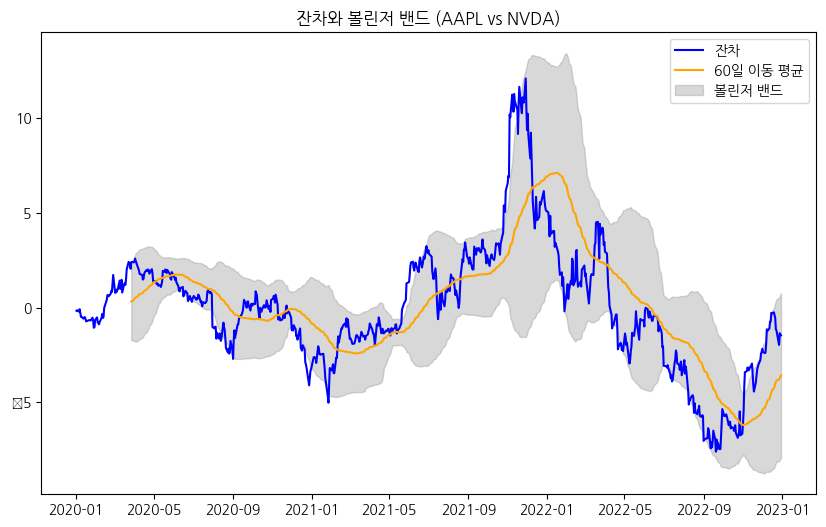


Analyzing Pair: AAPL and MSFT


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


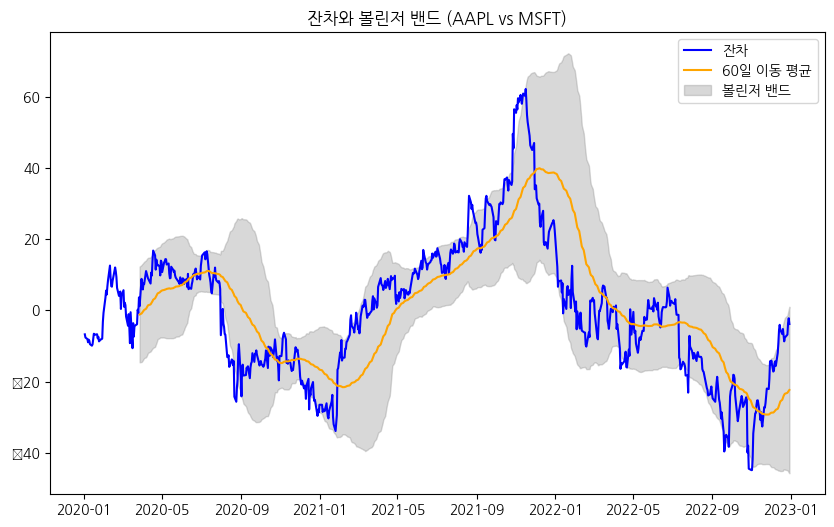


Analyzing Pair: AAPL and AVGO


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


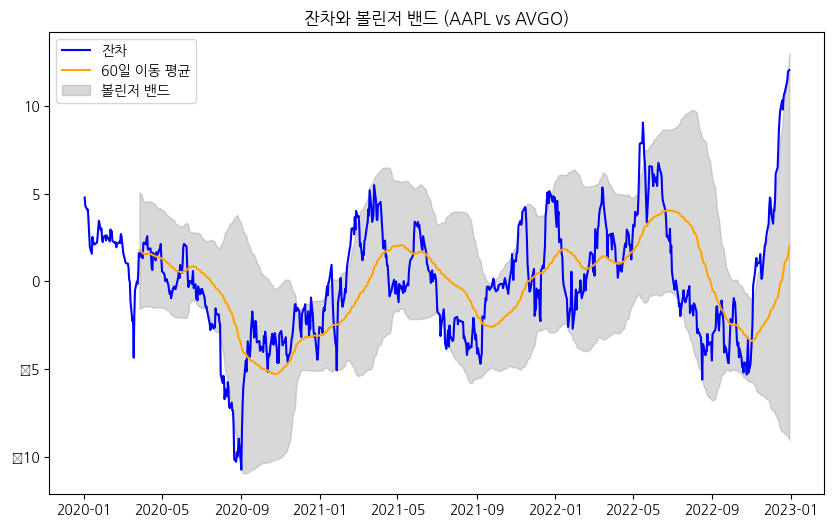


Analyzing Pair: NVDA and MSFT


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


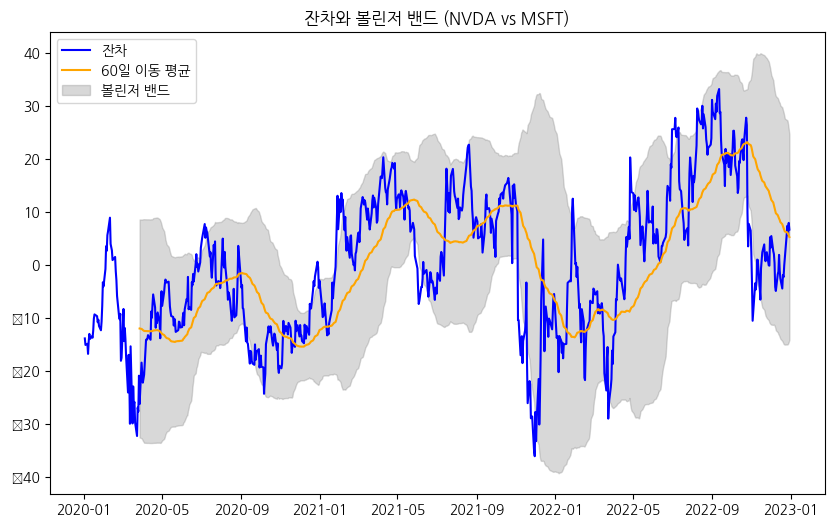


Analyzing Pair: NVDA and AVGO


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


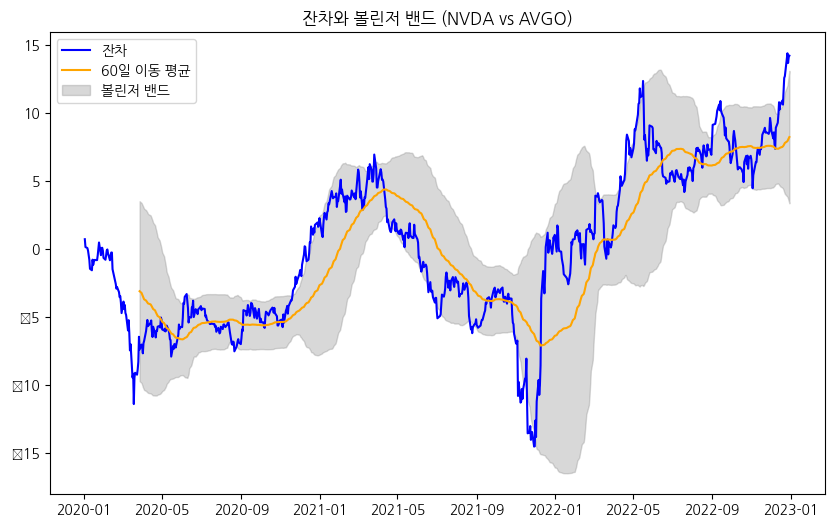


Analyzing Pair: MSFT and AVGO


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


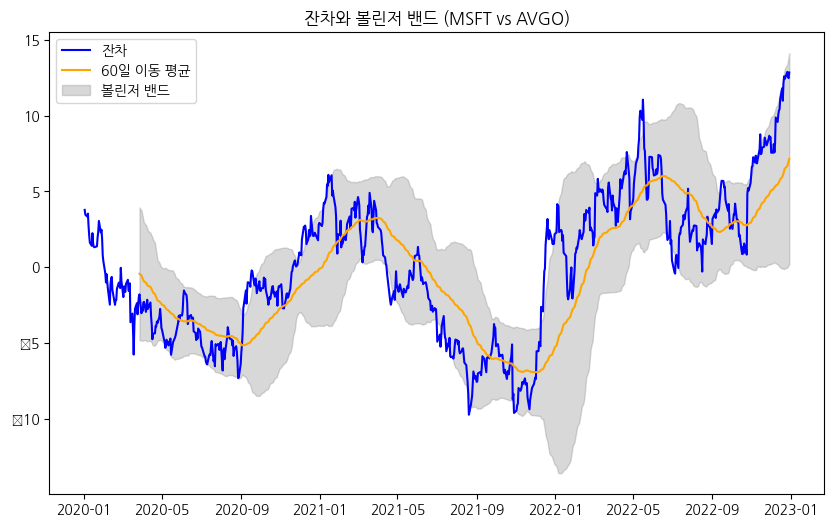

In [139]:
# 1. Information Technology 섹터의 모든 페어 분석
it_sector_tickers = top_by_sector.loc['Information Technology']['Symbol'].tolist()
analyze_sector_pairs(it_sector_tickers, start_date=default_start_date, end_date=default_end_date)

#### 1. 안정적 페어

[*********************100%***********************]  4 of 4 completed


Pair: AAPL and NVDA - 잔차 표준편차: 3.289123550681478, ADF p-value: 0.14526732386384272
Pair: AAPL and MSFT - 잔차 표준편차: 18.92905185929337, ADF p-value: 0.23252404120574782
Pair: AAPL and AVGO - 잔차 표준편차: 3.3883812448502866, ADF p-value: 0.2515024469860821
Pair: NVDA and MSFT - 잔차 표준편차: 13.446210923113783, ADF p-value: 0.024678204603320632
Pair: NVDA and AVGO - 잔차 표준편차: 5.650015267355996, ADF p-value: 0.6666303458121572
Pair: MSFT and AVGO - 잔차 표준편차: 4.64217016800478, ADF p-value: 0.6216065627352454

Analyzing Pair: NVDA and MSFT


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


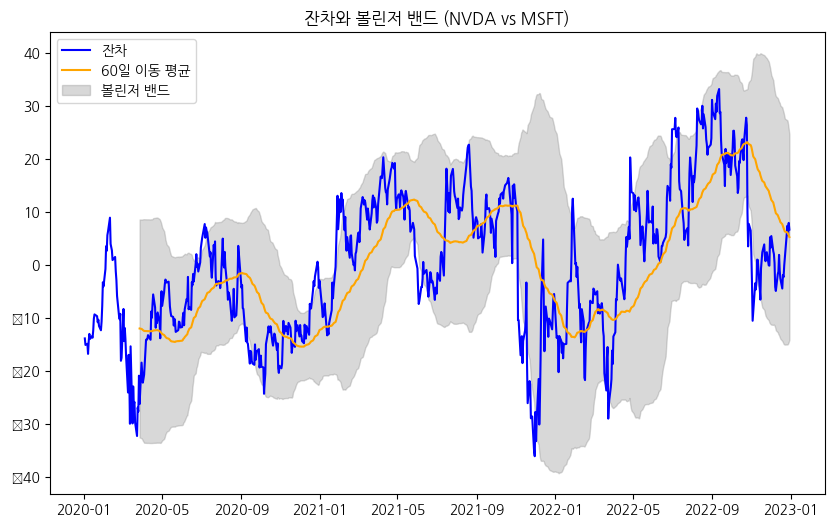

가장 안정적인 페어: ('NVDA', 'MSFT')


In [138]:
# 정보기술 Information Technology 섹터의 가장 안정적인 페어 선택
it_sector_tickers = top_by_sector.loc['Information Technology']['Symbol'].tolist()
stable_it_pair = select_stable_pair(it_sector_tickers, start_date=default_start_date, end_date=default_end_date)
print(f"가장 안정적인 페어: {stable_it_pair}")


### 2. Energy

#### 2. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed



Analyzing Pair: XOM and CVX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


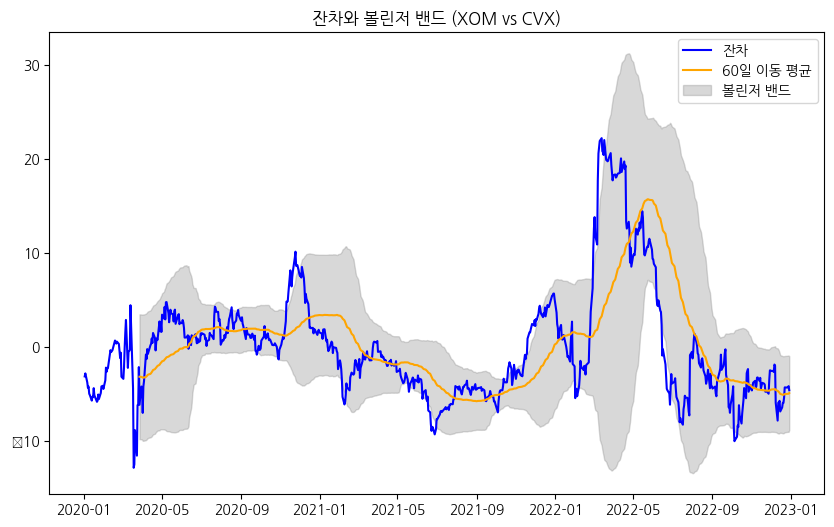


Analyzing Pair: XOM and COP


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


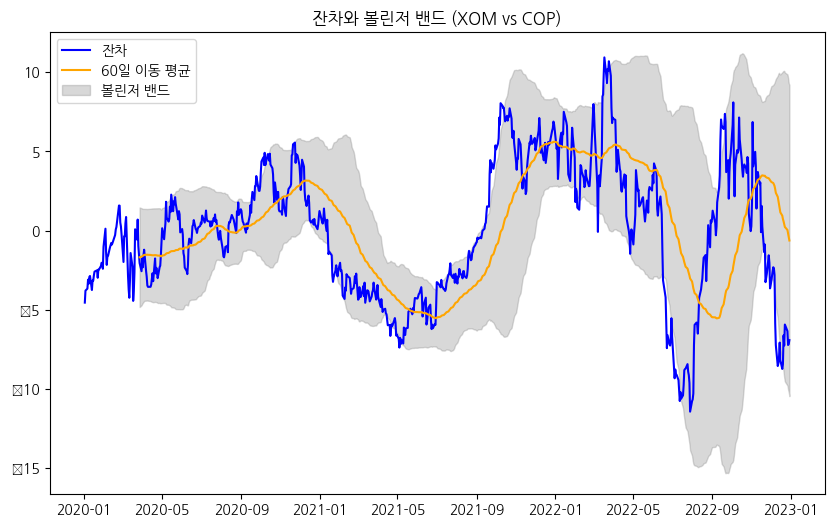


Analyzing Pair: XOM and EOG


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


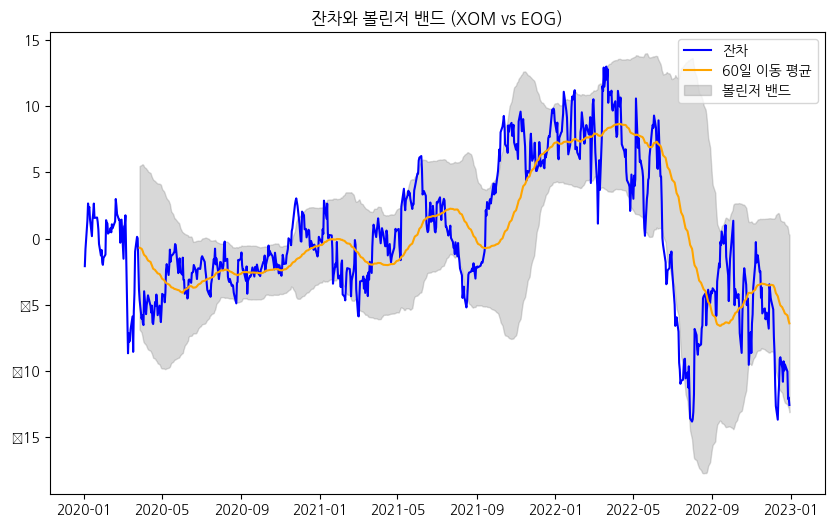


Analyzing Pair: CVX and COP


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


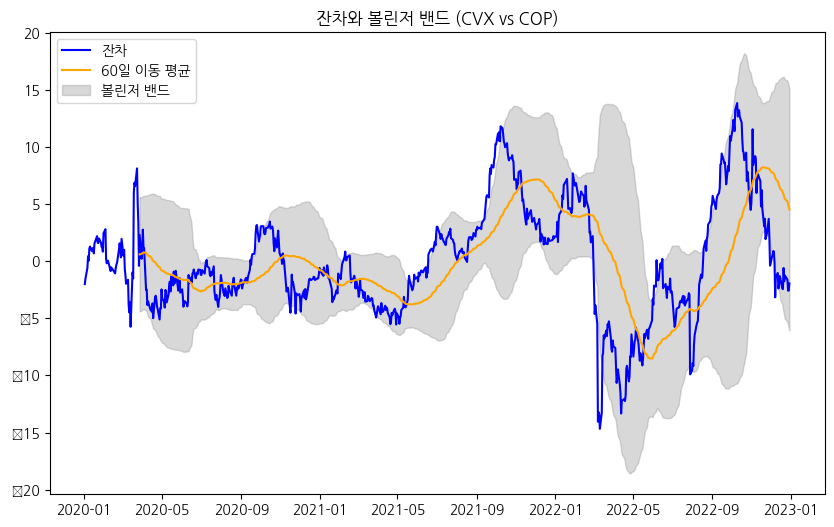


Analyzing Pair: CVX and EOG


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


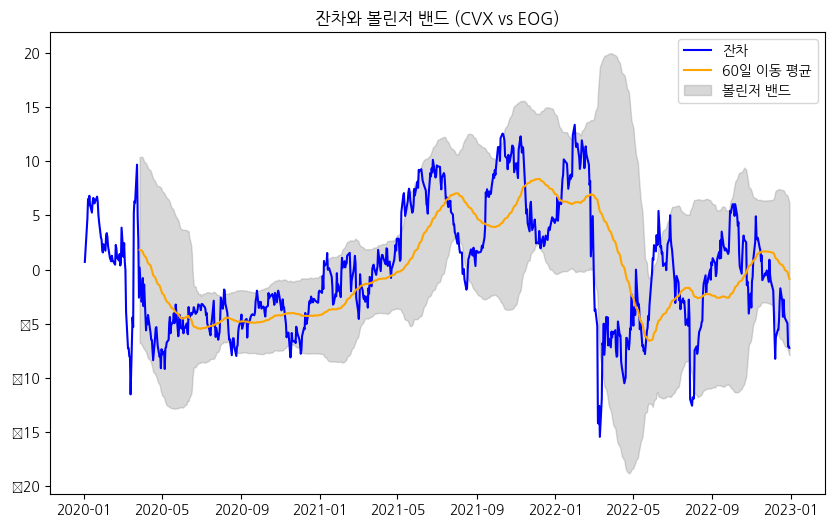


Analyzing Pair: COP and EOG


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


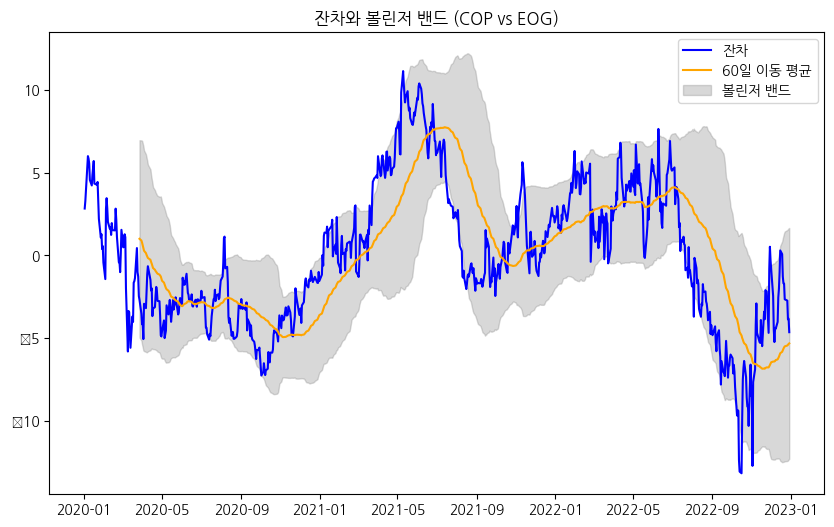

In [140]:
# 2. Energy 섹터의 모든 페어 분석
energy_sector_tickers = top_by_sector.loc['Energy']['Symbol'].tolist()
analyze_sector_pairs(energy_sector_tickers, start_date=default_start_date, end_date=default_end_date)

#### 2. 안정적 페어

[*********************100%***********************]  4 of 4 completed


Pair: XOM and CVX - 잔차 표준편차: 6.0660540539527545, ADF p-value: 0.02626149766164804
Pair: XOM and COP - 잔차 표준편차: 4.288954505295747, ADF p-value: 0.08086747259356719
Pair: XOM and EOG - 잔차 표준편차: 5.221209561043824, ADF p-value: 0.518780507087866
Pair: CVX and COP - 잔차 표준편차: 4.864789039491956, ADF p-value: 0.040691485157004645
Pair: CVX and EOG - 잔차 표준편차: 5.5716573806286425, ADF p-value: 0.0386776002461242
Pair: COP and EOG - 잔차 표준편차: 4.241059195537333, ADF p-value: 0.26434783053059485

Analyzing Pair: CVX and COP


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


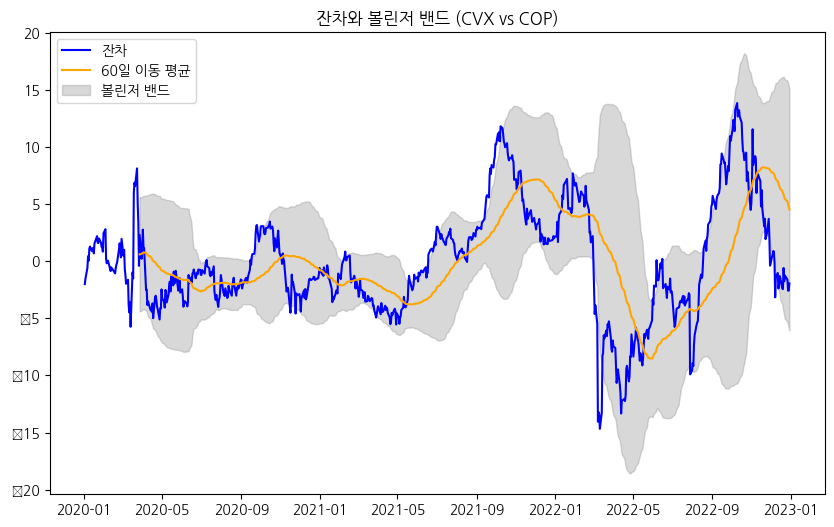

가장 안정적인 페어: ('CVX', 'COP')


In [141]:
# Energy 섹터의 가장 안정적인 페어 선택
it_sector_tickers = top_by_sector.loc['Energy']['Symbol'].tolist()
stable_it_pair = select_stable_pair(it_sector_tickers,  start_date=default_start_date, end_date=default_end_date)
print(f"가장 안정적인 페어: {stable_it_pair}")


### 3. Consumer Discretionary

#### 3. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



Analyzing Pair: AMZN and TSLA


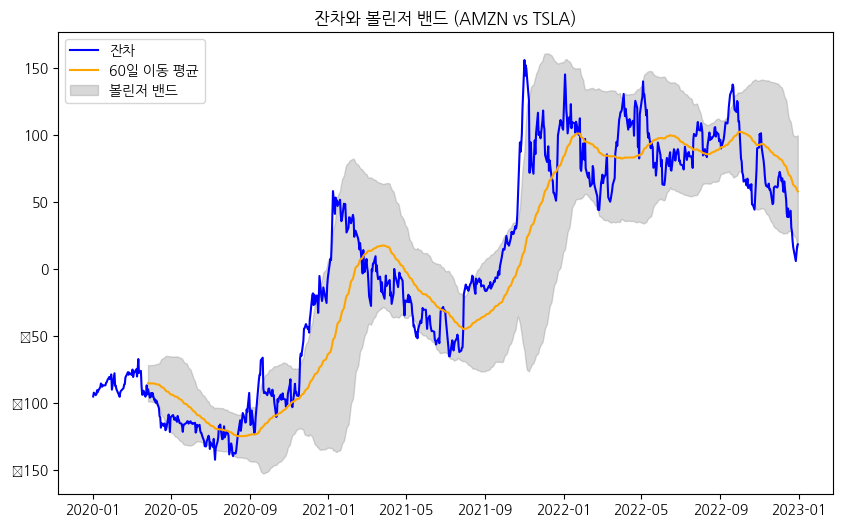


Analyzing Pair: AMZN and HD


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


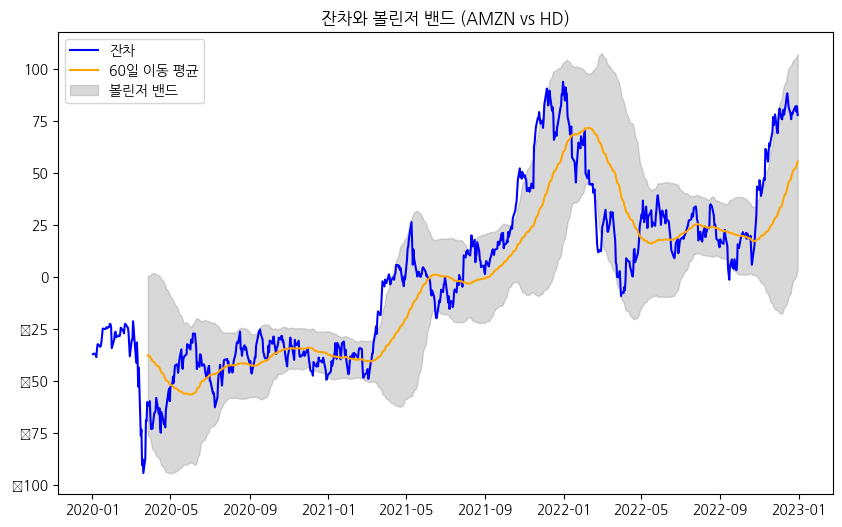


Analyzing Pair: AMZN and MCD


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


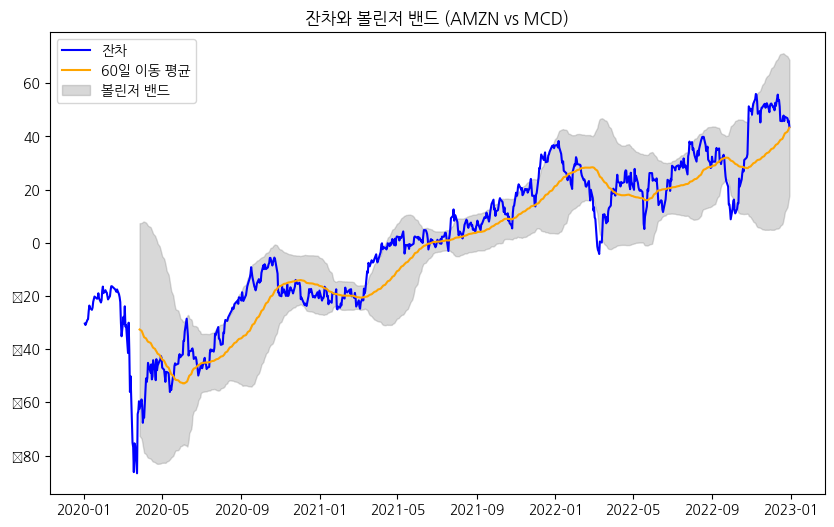


Analyzing Pair: TSLA and HD


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


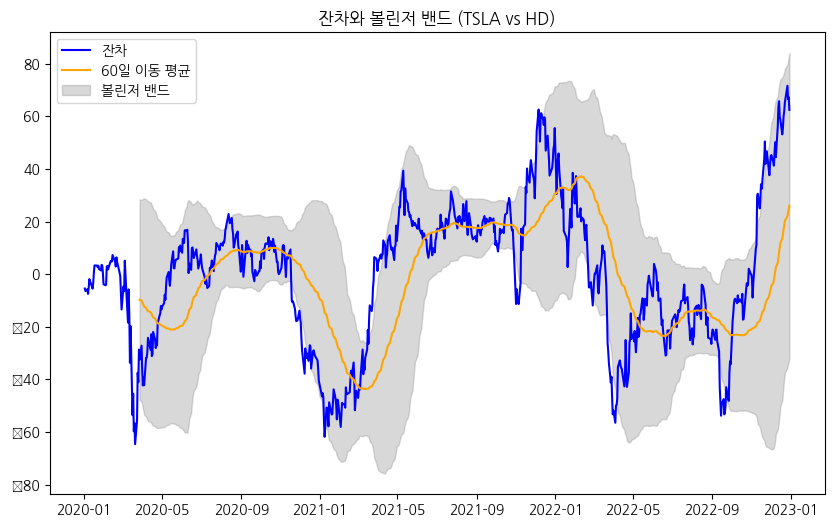


Analyzing Pair: TSLA and MCD


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


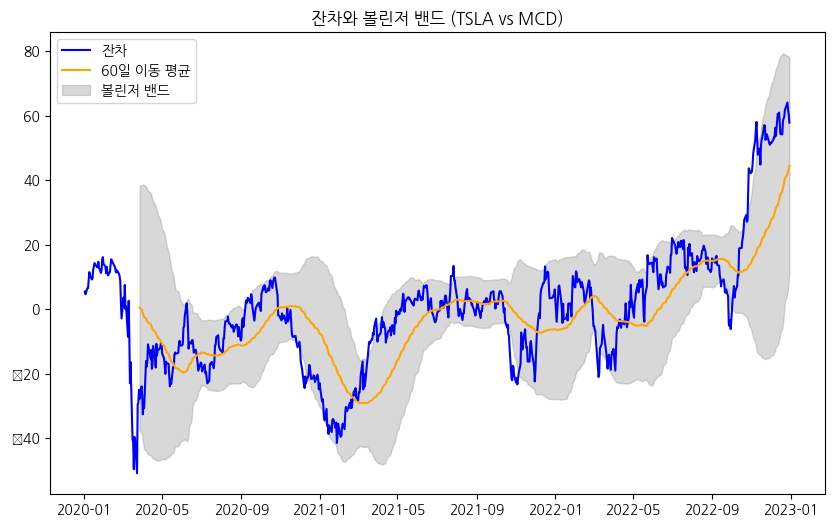


Analyzing Pair: HD and MCD


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


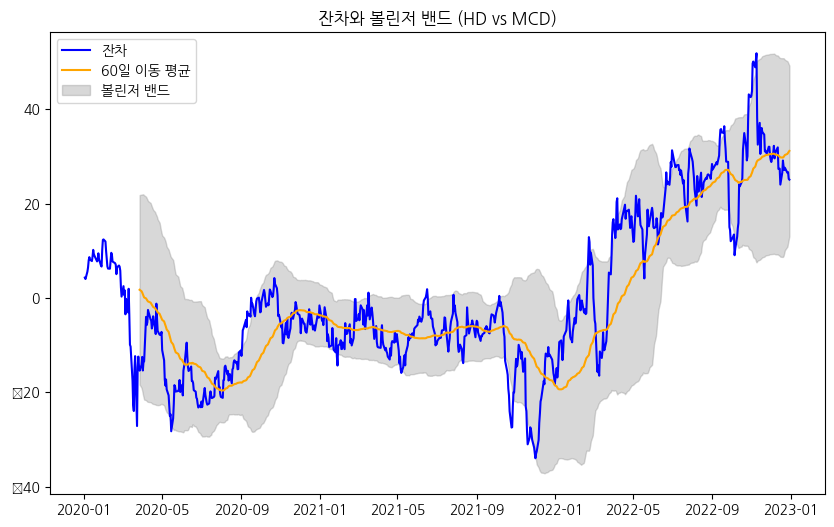

In [144]:
# 3. Consumer Discretionary 섹터의 모든 페어 분석
consumer_discretionary_tickers = top_by_sector.loc['Consumer Discretionary']['Symbol'].tolist()
analyze_sector_pairs(consumer_discretionary_tickers,  start_date=default_start_date, end_date=default_end_date)

#### 3. 안정적 페어

[*********************100%***********************]  10 of 10 completed


Pair: AMZN and TSLA - 잔차 표준편차: 82.77217090457077, ADF p-value: 0.4865716337483333
Pair: AMZN and HD - 잔차 표준편차: 40.52793668348117, ADF p-value: 0.7518130959061714
Pair: AMZN and MCD - 잔차 표준편차: 28.47324868134795, ADF p-value: 0.7588384402295836
Pair: AMZN and LOW - 잔차 표준편차: 35.24334057308099, ADF p-value: 0.8026489863554152
Pair: AMZN and BKNG - 잔차 표준편차: 253.7195420663381, ADF p-value: 0.10069492720935197
Pair: AMZN and TJX - 잔차 표준편차: 7.758649610558408, ADF p-value: 0.7589984138168497
Pair: AMZN and NKE - 잔차 표준편차: 15.394474599573055, ADF p-value: 0.3881808591808481
Pair: AMZN and SBUX - 잔차 표준편차: 11.612338019819784, ADF p-value: 0.7221592041110823
Pair: AMZN and ABNB contains insufficient data (all NaNs or infs). Skipping this pair.
Pair: TSLA and HD - 잔차 표준편차: 26.54278562473941, ADF p-value: 0.22826603678028184
Pair: TSLA and MCD - 잔차 표준편차: 19.202000043171317, ADF p-value: 0.561375398211719
Pair: TSLA and LOW - 잔차 표준편차: 18.18424213094161, ADF p-value: 0.24684110024525058
Pair: TSLA and B

C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


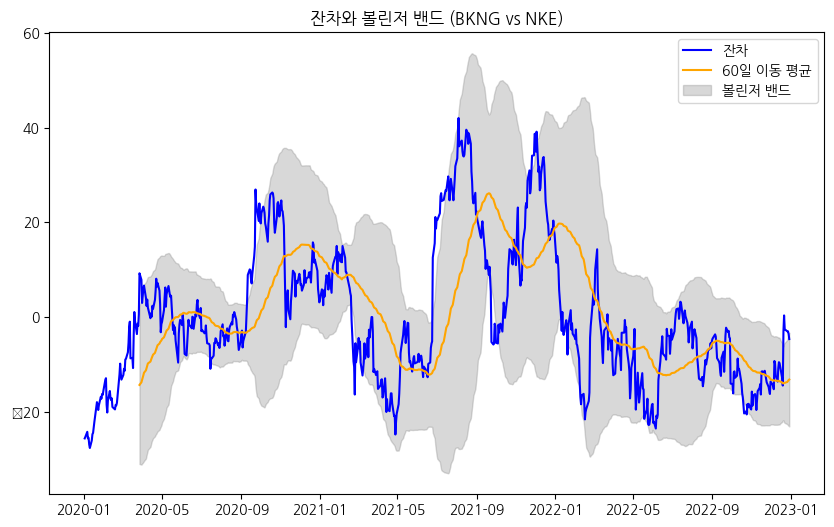

가장 안정적인 페어: ('BKNG', 'NKE')


In [143]:
# 임의소비재Consumer Discretionary 섹터의 가장 안정적인 페어 선택

# Consumer Discretionary 섹터의 시가총액 상위 10개 종목 선택 (기존 4개에서 확장)
consumer_discretionary_top = sp500[sp500['GICS Sector'] == 'Consumer Discretionary'].nlargest(10, 'Market Cap')

# Consumer Discretionary 섹터의 종목 티커 리스트 생성
consumer_tickers = consumer_discretionary_top['Symbol'].tolist()

#it_sector_tickers = top_by_sector.loc['Consumer Discretionary']['Symbol'].tolist()
stable_consumer_pair = select_stable_pair(consumer_tickers, start_date=default_start_date, end_date=default_end_date, adf_threshold = 0.05)
print(f"가장 안정적인 페어: {stable_consumer_pair}")


### 4. Health Care

#### 4. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed



Analyzing Pair: LLY and UNH


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


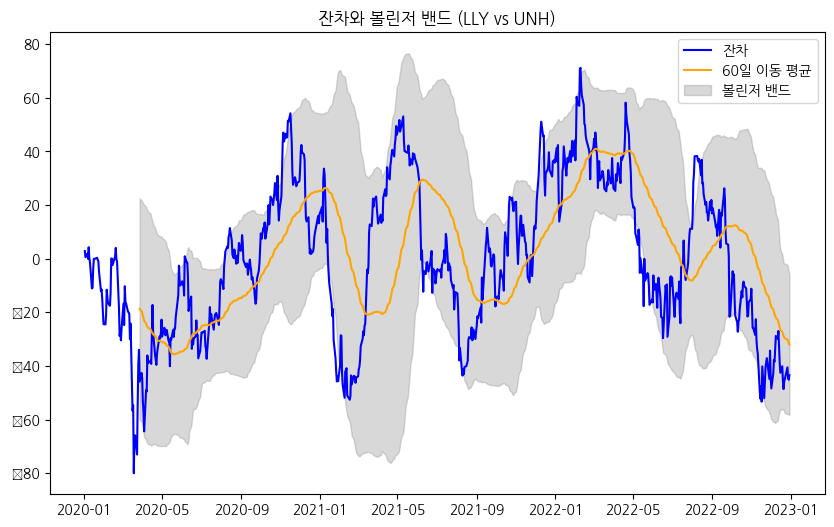


Analyzing Pair: LLY and JNJ


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


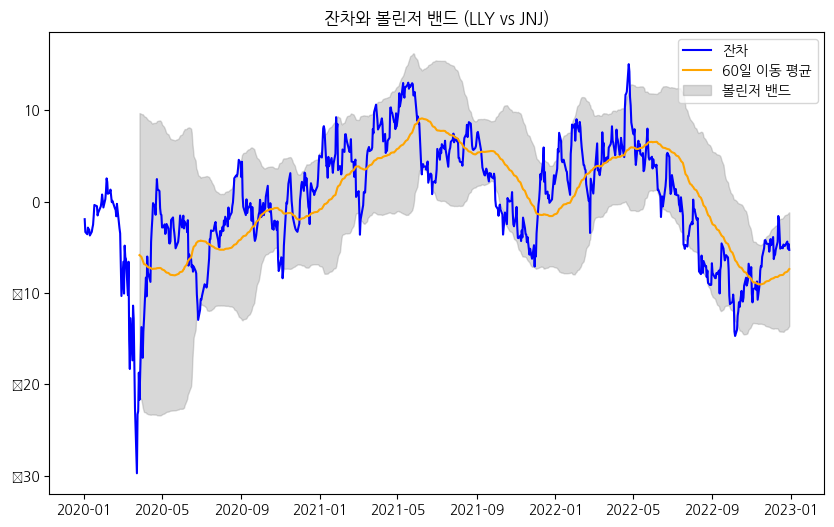


Analyzing Pair: LLY and ABBV


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


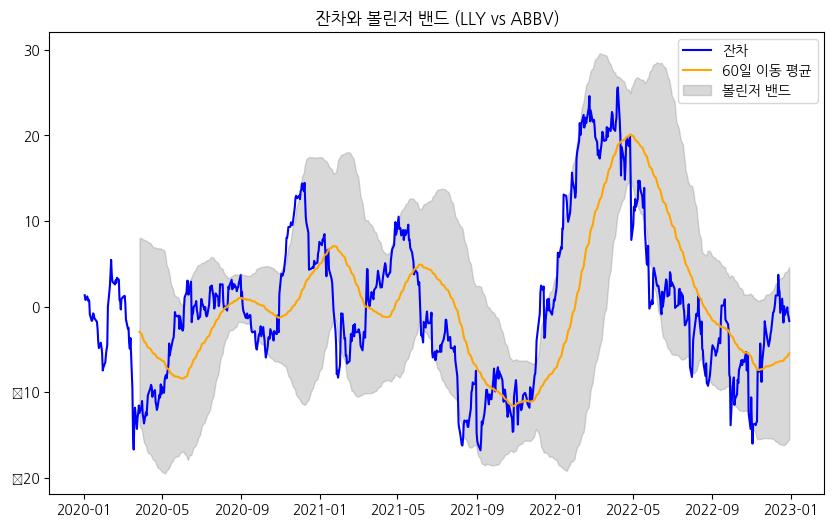


Analyzing Pair: UNH and JNJ


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


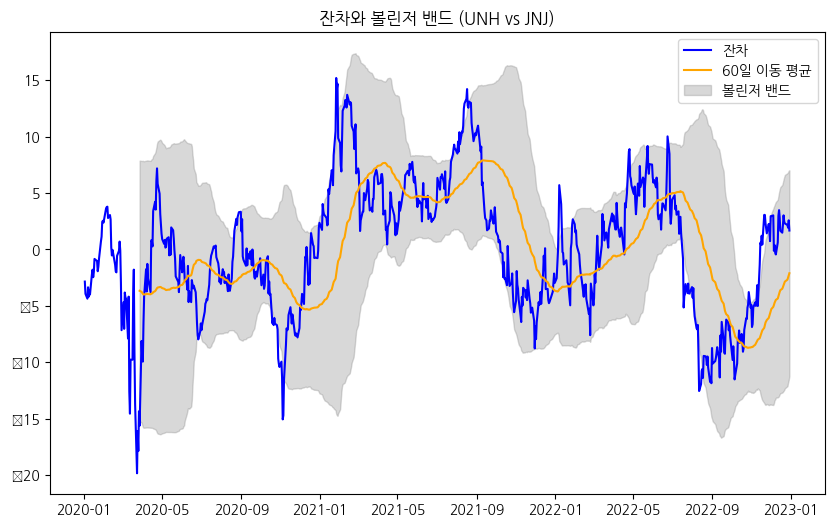


Analyzing Pair: UNH and ABBV


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


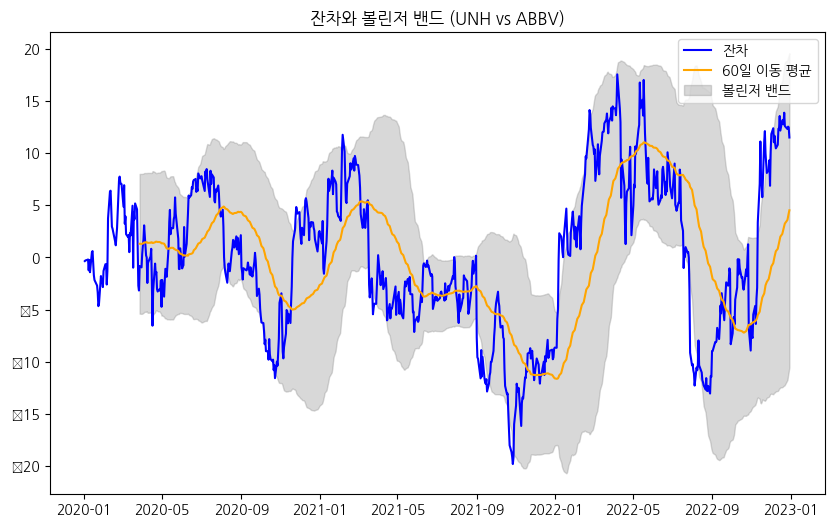


Analyzing Pair: JNJ and ABBV


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


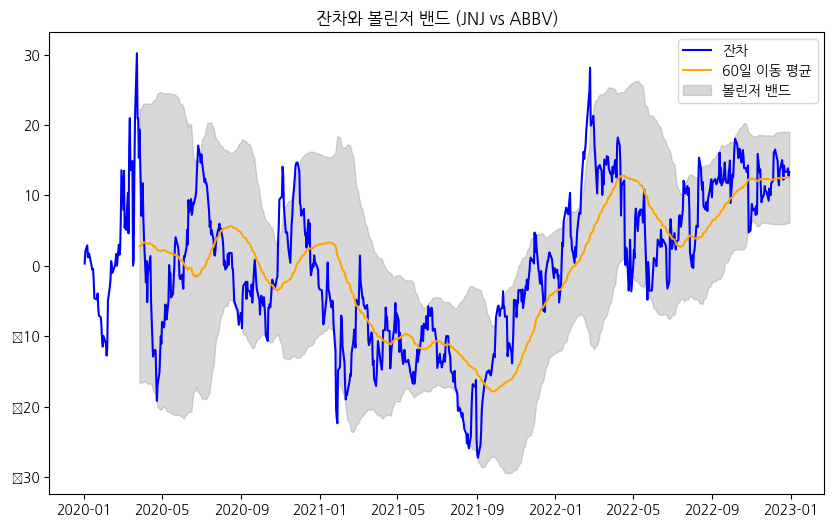

In [145]:
# 4. Health Care 섹터의 모든 페어 분석
health_care_tickers = top_by_sector.loc['Health Care']['Symbol'].tolist()
analyze_sector_pairs(health_care_tickers, start_date=default_start_date, end_date=default_end_date)

#### 4. 안정적 페어

[*********************100%***********************]  4 of 4 completed


Pair: LLY and UNH - 잔차 표준편차: 28.287363894534128, ADF p-value: 0.052516742344555174
Pair: LLY and JNJ - 잔차 표준편차: 6.359334827449091, ADF p-value: 0.048498701842625294
Pair: LLY and ABBV - 잔차 표준편차: 8.917844136106703, ADF p-value: 0.10076497994010364
Pair: UNH and JNJ - 잔차 표준편차: 5.79557940529695, ADF p-value: 0.026420826346418295
Pair: UNH and ABBV - 잔차 표준편차: 7.246147867352283, ADF p-value: 0.03546831823594401
Pair: JNJ and ABBV - 잔차 표준편차: 10.638652278532636, ADF p-value: 0.016099124432880304

Analyzing Pair: UNH and JNJ


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


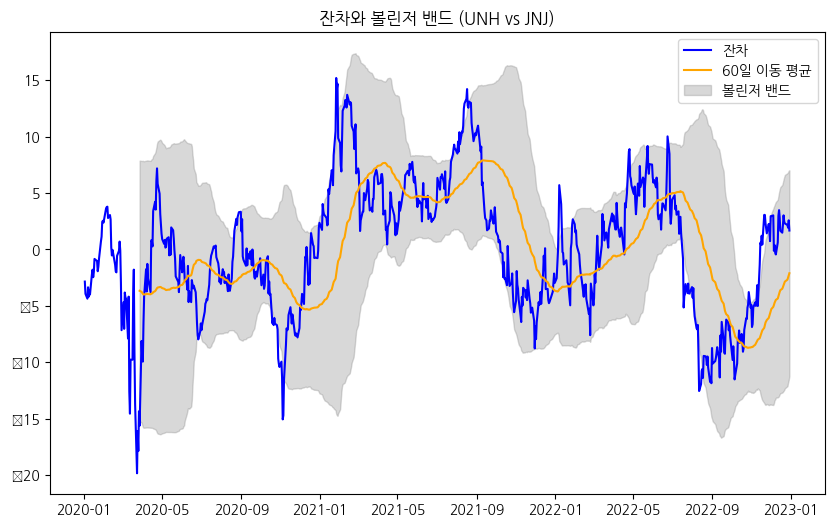

가장 안정적인 페어: ('UNH', 'JNJ')


In [146]:
# Health Care 섹터의 가장 안정적인 페어 선택
it_sector_tickers = top_by_sector.loc['Health Care']['Symbol'].tolist()
stable_it_pair = select_stable_pair(it_sector_tickers,  start_date=default_start_date, end_date=default_end_date)
print(f"가장 안정적인 페어: {stable_it_pair}")


### 5. Financials

#### 5. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed



Analyzing Pair: JPM and V


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


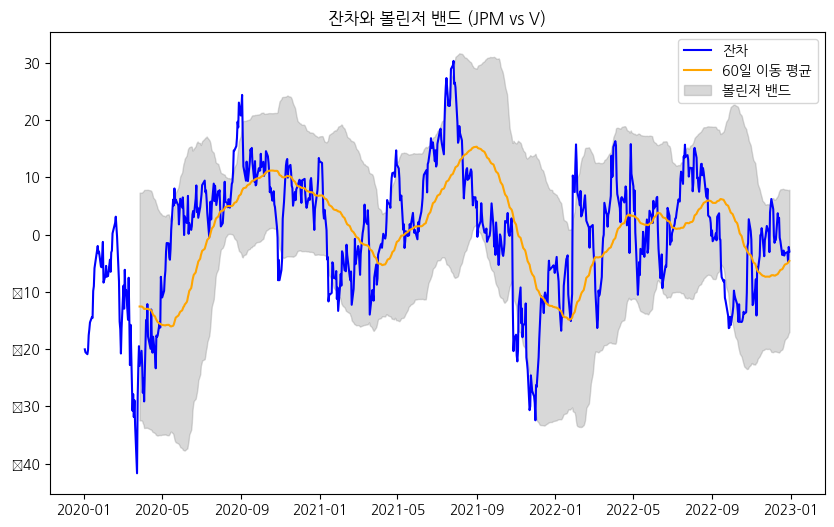


Analyzing Pair: JPM and MA


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


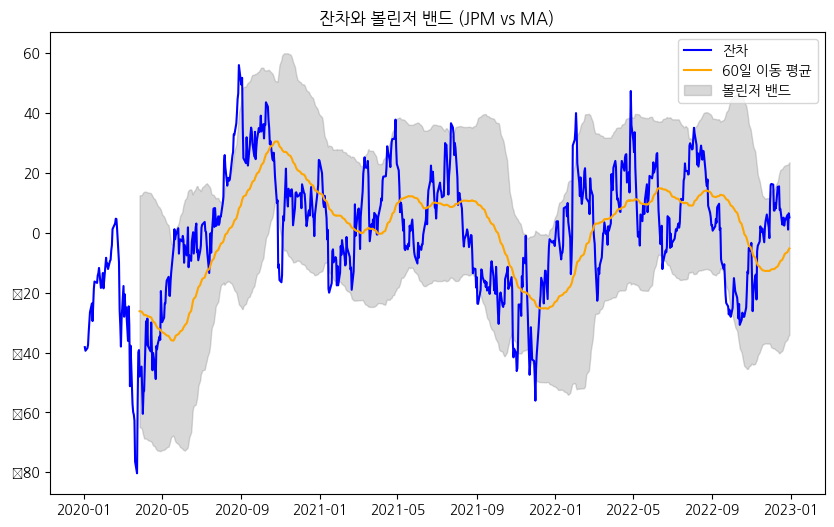


Analyzing Pair: JPM and BAC


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


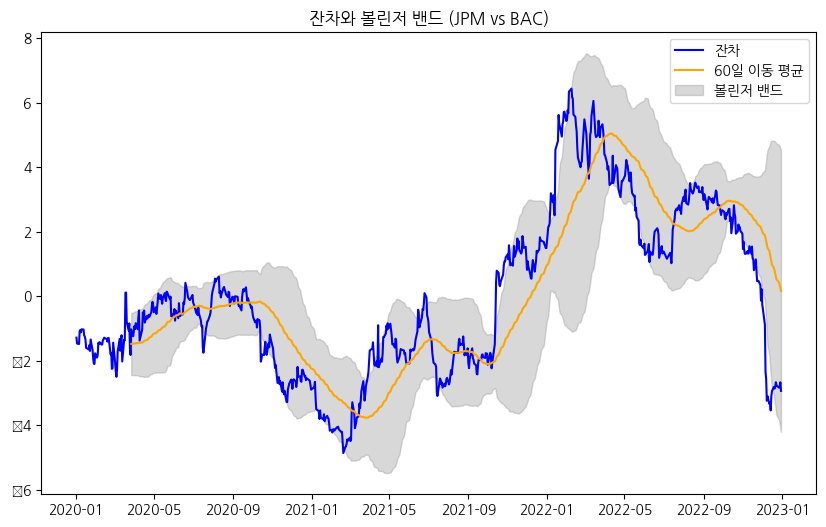


Analyzing Pair: V and MA


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


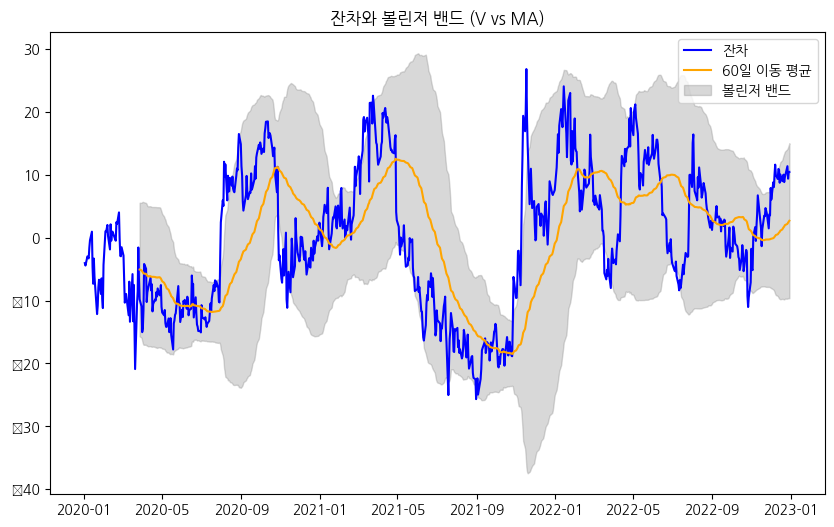


Analyzing Pair: V and BAC


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


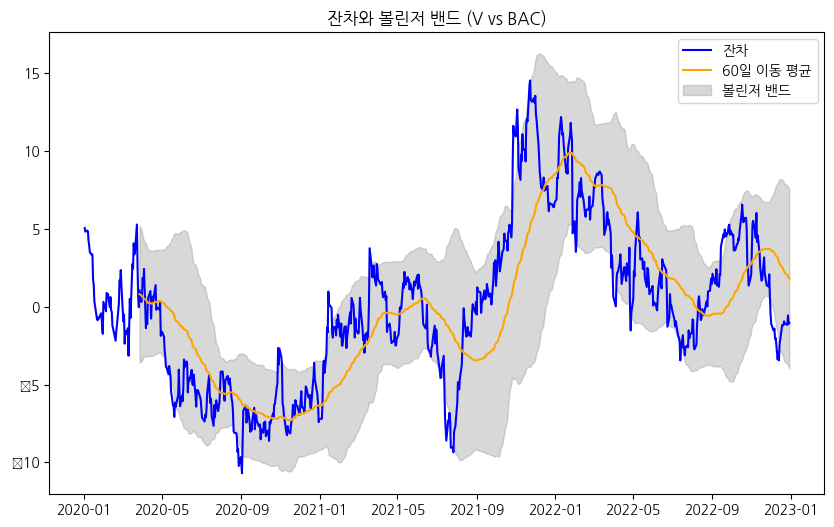


Analyzing Pair: MA and BAC


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


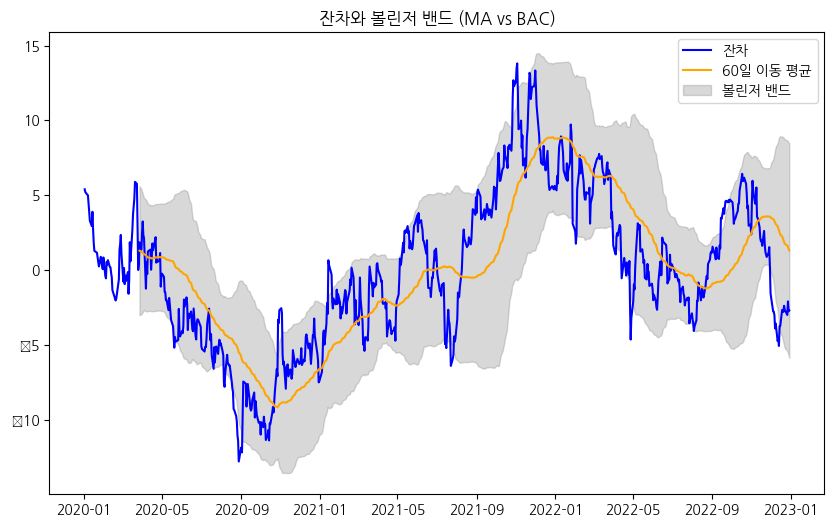

In [147]:
# 5. Financials 섹터의 모든 페어 분석
financials_tickers = top_by_sector.loc['Financials']['Symbol'].tolist()
analyze_sector_pairs(financials_tickers, start_date=default_start_date, end_date=default_end_date)


#### 5. 안정적 페어

[*********************100%***********************]  4 of 4 completed


Pair: JPM and V - 잔차 표준편차: 11.060459065451942, ADF p-value: 0.01203855423159782
Pair: JPM and MA - 잔차 표준편차: 21.232934199681257, ADF p-value: 0.0008397171557213069
Pair: JPM and BAC - 잔차 표준편차: 2.5151728316837767, ADF p-value: 0.56628731035615
Pair: V and MA - 잔차 표준편차: 10.97236965761557, ADF p-value: 0.043102583737479716
Pair: V and BAC - 잔차 표준편차: 5.047406921071075, ADF p-value: 0.08213891054211664
Pair: MA and BAC - 잔차 표준편차: 5.035855451714992, ADF p-value: 0.07249275920897763

Analyzing Pair: V and MA


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


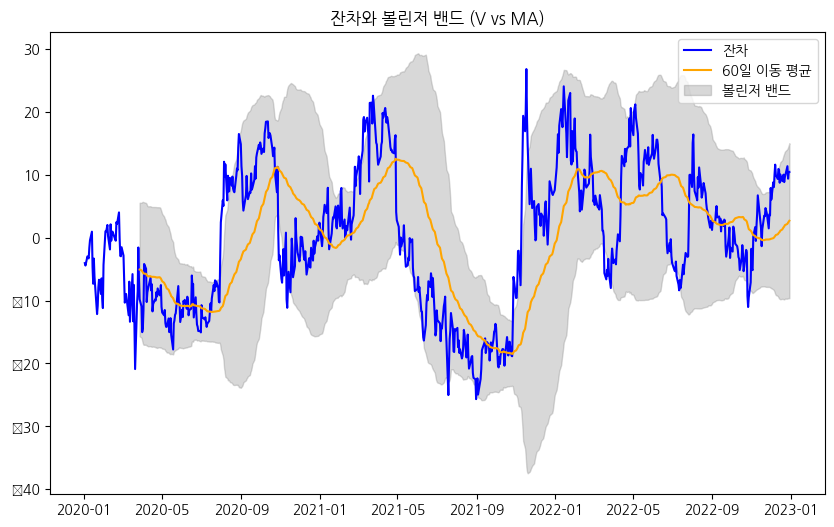

가장 안정적인 페어: ('V', 'MA')


In [148]:
# Financials 섹터의 가장 안정적인 페어 선택
it_sector_tickers = top_by_sector.loc['Financials']['Symbol'].tolist()
stable_it_pair = select_stable_pair(it_sector_tickers, start_date=default_start_date, end_date=default_end_date)
print(f"가장 안정적인 페어: {stable_it_pair}")


### 6. Communication Services

#### 6. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



Analyzing Pair: GOOGL and GOOG


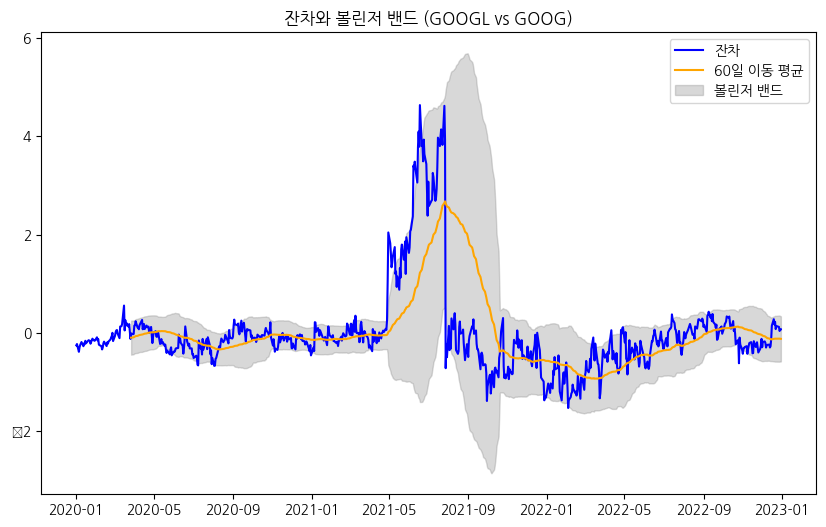


Analyzing Pair: GOOGL and META


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


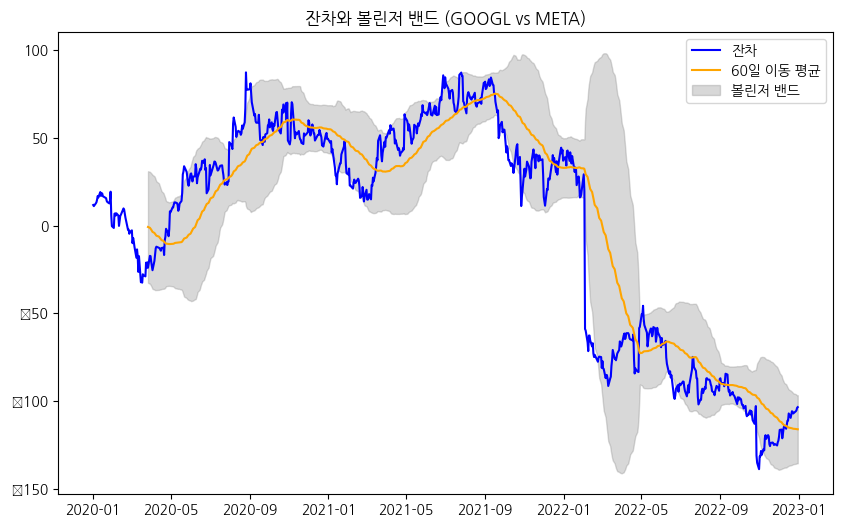


Analyzing Pair: GOOGL and NFLX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


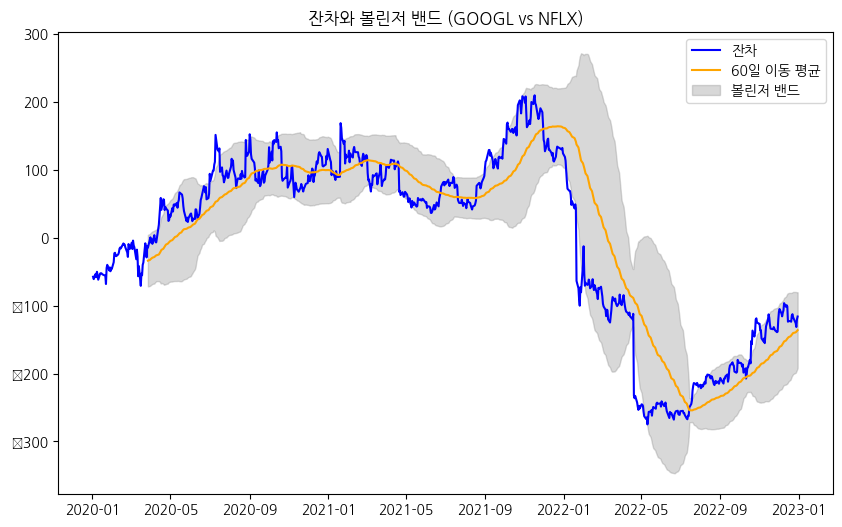


Analyzing Pair: GOOG and META


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


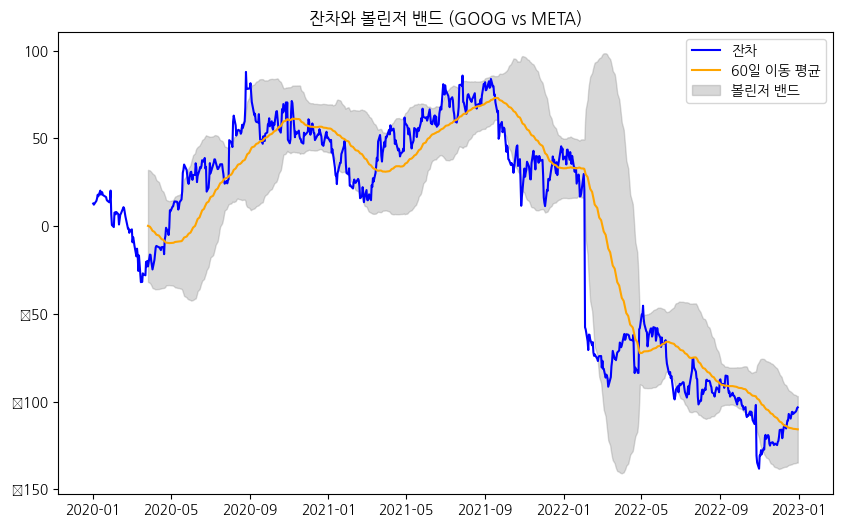


Analyzing Pair: GOOG and NFLX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


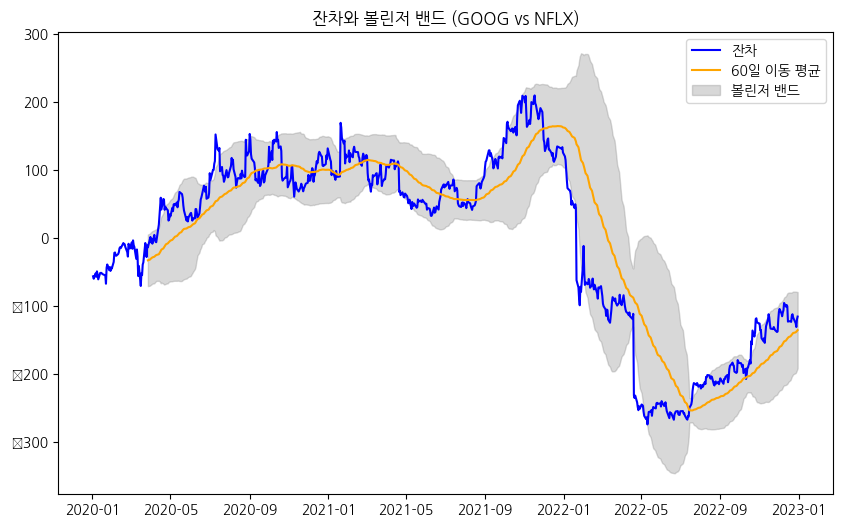


Analyzing Pair: META and NFLX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


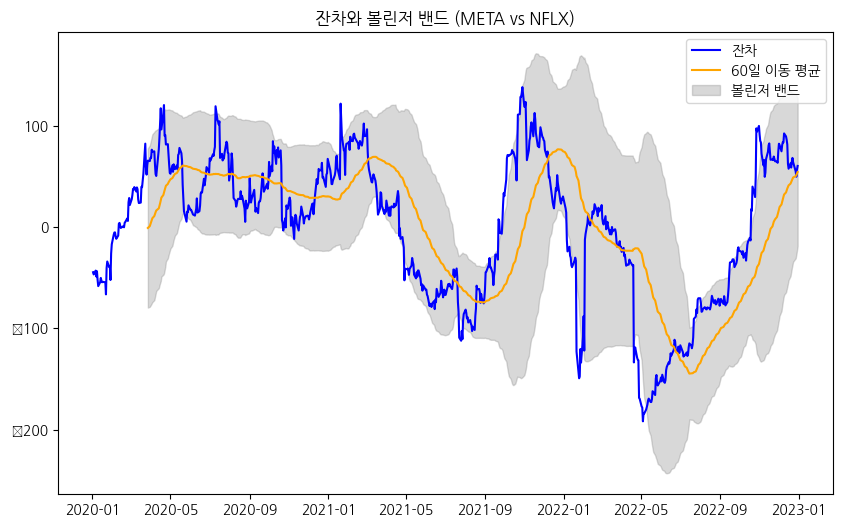

In [149]:
# 6. Communication Services 섹터의 모든 페어 분석

financials_tickers = top_by_sector.loc['Communication Services']['Symbol'].tolist()
analyze_sector_pairs(financials_tickers, start_date=default_start_date, end_date=default_end_date)


#### 6. 안정적 페어

[*********************100%***********************]  10 of 10 completed


Pair: GOOGL and GOOG - 잔차 표준편차: 0.9151418773447403, ADF p-value: 0.12468856108970389
Pair: GOOGL and META - 잔차 표준편차: 63.86068615492682, ADF p-value: 0.860356712696529
Pair: GOOGL and NFLX - 잔차 표준편차: 130.5780002940006, ADF p-value: 0.7015731087004211
Pair: GOOGL and TMUS - 잔차 표준편차: 15.335452900960028, ADF p-value: 0.3572761592614302
Pair: GOOGL and VZ - 잔차 표준편차: 4.139038885370664, ADF p-value: 0.7329411888246511
Pair: GOOGL and DIS - 잔차 표준편차: 27.989227000597413, ADF p-value: 0.7729914858909466
Pair: GOOGL and CMCSA - 잔차 표준편차: 5.68623061791167, ADF p-value: 0.6215438368290105
Pair: GOOGL and T - 잔차 표준편차: 1.3279016268497028, ADF p-value: 0.001822252116573355
Pair: GOOGL and CHTR - 잔차 표준편차: 105.45031898438236, ADF p-value: 0.8614116005526112
Pair: GOOG and META - 잔차 표준편차: 63.552585549730516, ADF p-value: 0.859662799904737
Pair: GOOG and NFLX - 잔차 표준편차: 130.49506315757384, ADF p-value: 0.7021690961050127
Pair: GOOG and TMUS - 잔차 표준편차: 15.214313077504857, ADF p-value: 0.3589153116245073
Pair

C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


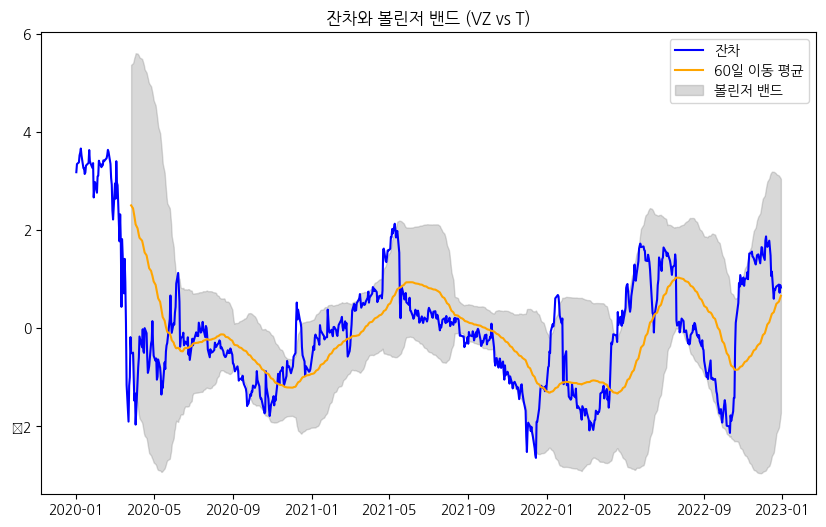

Communication Services 가장 안정적인 페어: ('VZ', 'T')


In [150]:
# Communication Services 섹터의 시가총액 상위 10개 종목 선택 (기존 4개에서 확장)
communication_services_top = sp500[sp500['GICS Sector'] == 'Communication Services'].nlargest(10, 'Market Cap')

# Communication Services 섹터의 종목 티커 리스트 생성
communication_tickers = communication_services_top['Symbol'].tolist()

# 페어 분석 및 안정적인 페어 선택 (ADF p-value 기준 0.05로 설정)
stable_communication_pair = select_stable_pair(communication_tickers, start_date=default_start_date, end_date=default_end_date, adf_threshold=0.05)
print(f"Communication Services 가장 안정적인 페어: {stable_communication_pair}")


### 7. Consumer Staples

#### 7. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



Analyzing Pair: WMT and COST


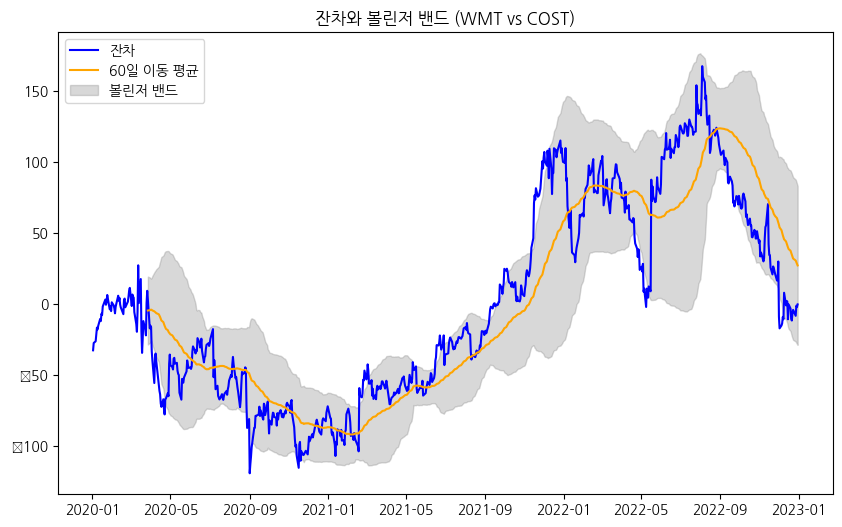


Analyzing Pair: WMT and PG


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


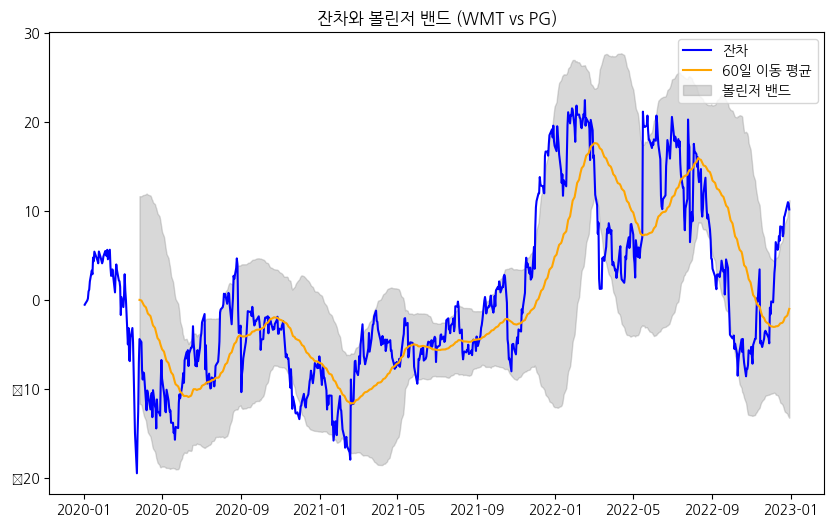


Analyzing Pair: WMT and KO


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


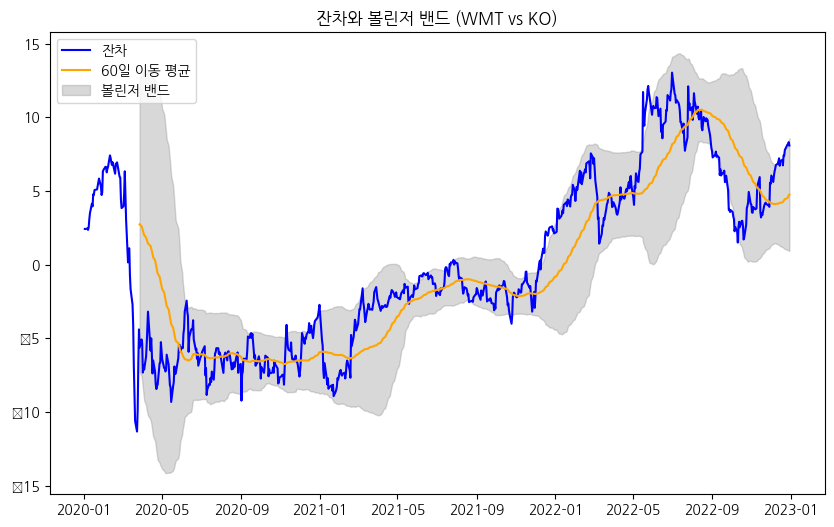


Analyzing Pair: COST and PG


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


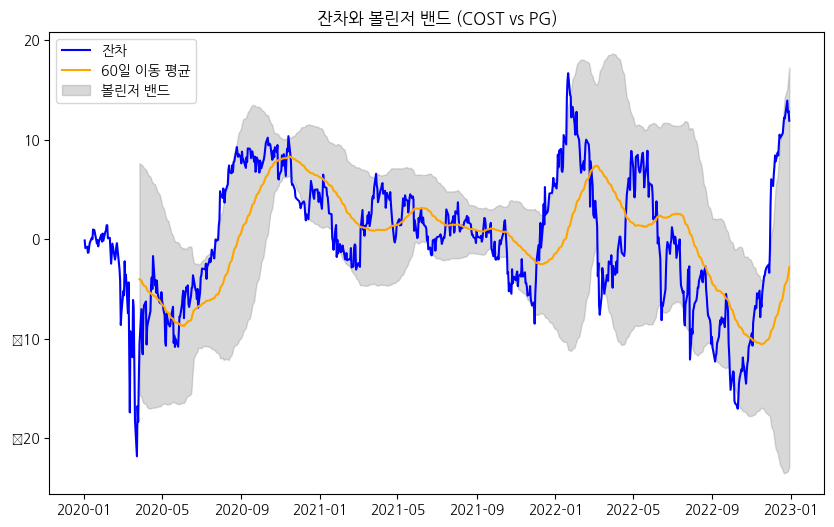


Analyzing Pair: COST and KO


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


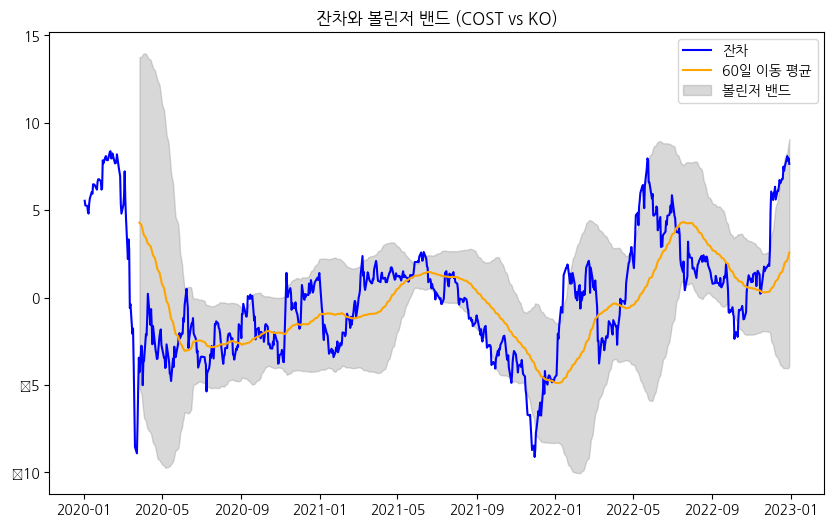


Analyzing Pair: PG and KO


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


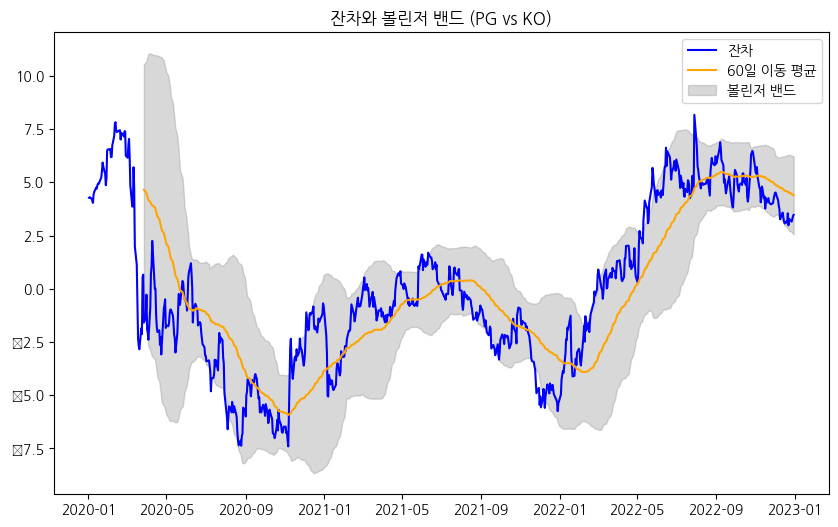

In [151]:
# 7. Consumer Staples 섹터의 모든 페어 분석

financials_tickers = top_by_sector.loc['Consumer Staples']['Symbol'].tolist()
analyze_sector_pairs(financials_tickers, start_date=default_start_date, end_date=default_end_date)

#### 7. 안정적 페어

[*********************100%***********************]  4 of 4 completed


Pair: WMT and COST - 잔차 표준편차: 69.01808319039658, ADF p-value: 0.5392880460179761
Pair: WMT and PG - 잔차 표준편차: 9.349598714073071, ADF p-value: 0.22469861595090157
Pair: WMT and KO - 잔차 표준편차: 5.782665230573869, ADF p-value: 0.5808202877385091
Pair: COST and PG - 잔차 표준편차: 6.341699713495375, ADF p-value: 0.0623055567659254
Pair: COST and KO - 잔차 표준편차: 3.3364893538578144, ADF p-value: 0.046424187478810205
Pair: PG and KO - 잔차 표준편차: 3.7632545212439608, ADF p-value: 0.37179042412373275

Analyzing Pair: COST and KO


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


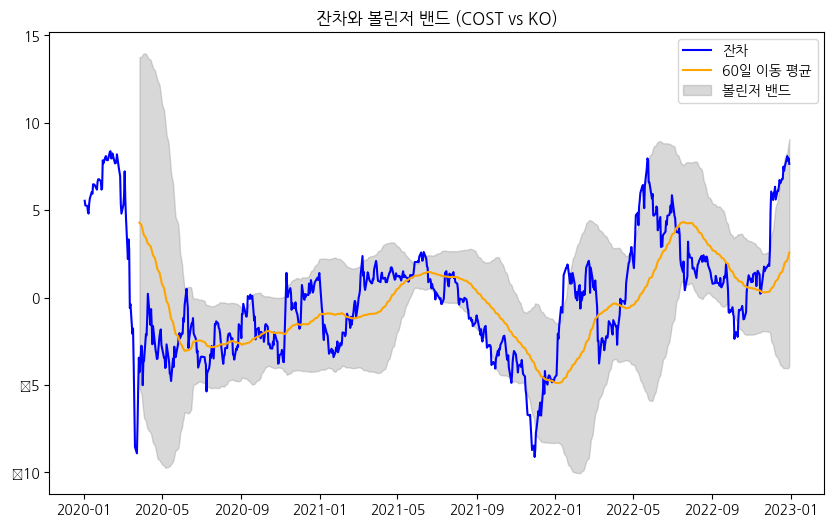

가장 안정적인 페어: ('COST', 'KO')


In [152]:
# 필수 소비재 Consumer Staples 섹터의 가장 안정적인 페어 선택
it_sector_tickers = top_by_sector.loc['Consumer Staples']['Symbol'].tolist()
stable_it_pair = select_stable_pair(it_sector_tickers, start_date=default_start_date, end_date=default_end_date)
print(f"가장 안정적인 페어: {stable_it_pair}")


### 8. Industrials

#### 8. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



Analyzing Pair: GE and CAT


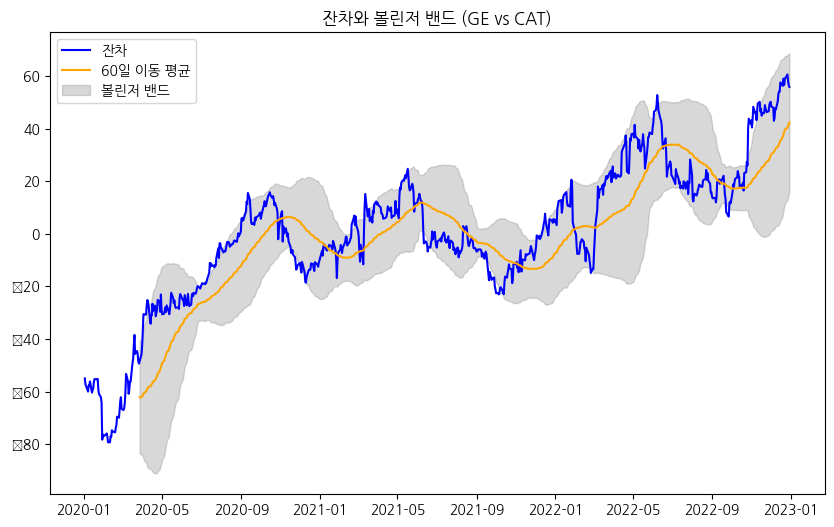


Analyzing Pair: GE and RTX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


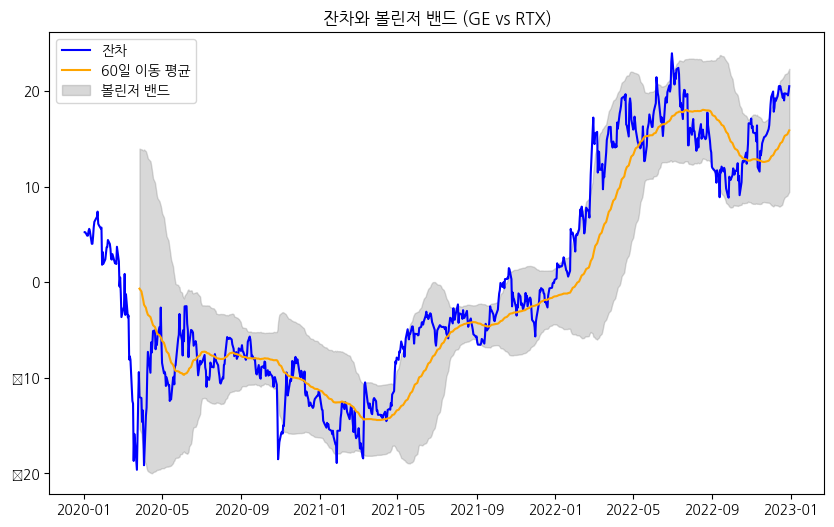


Analyzing Pair: GE and UBER


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


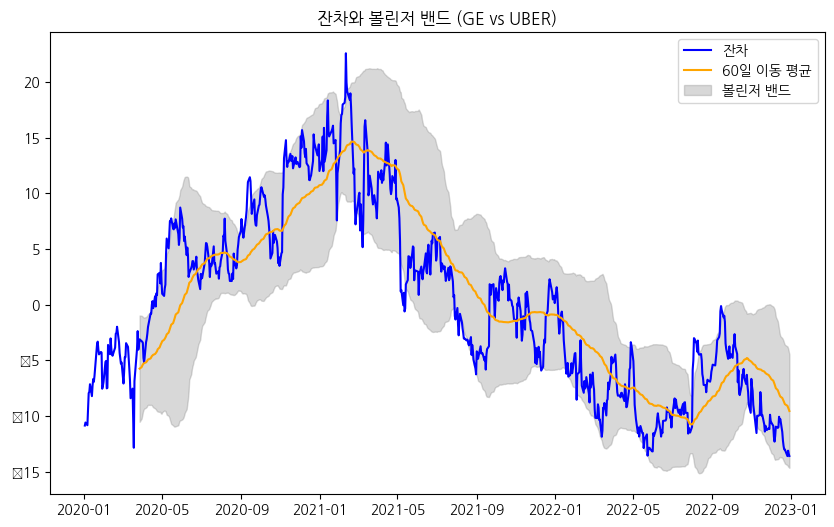


Analyzing Pair: CAT and RTX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


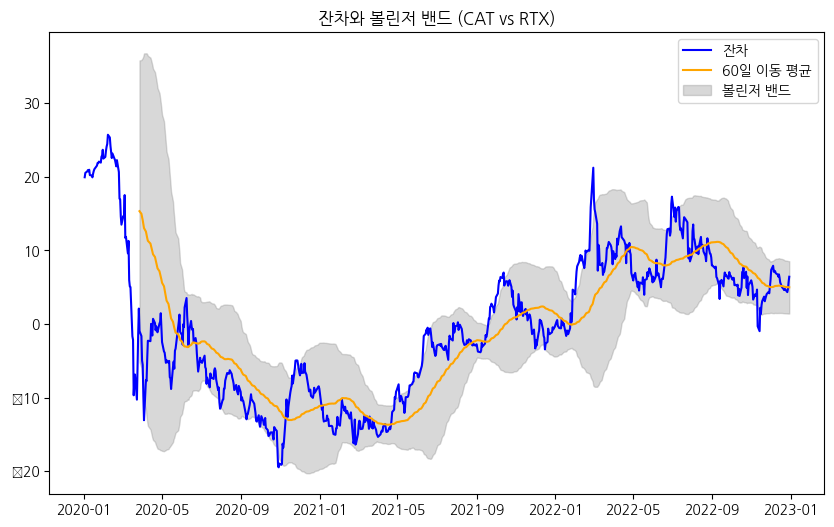


Analyzing Pair: CAT and UBER


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


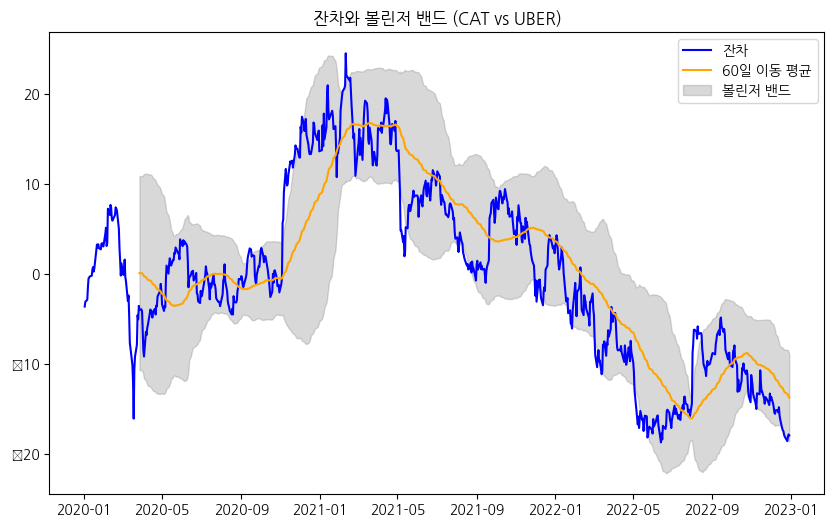


Analyzing Pair: RTX and UBER


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


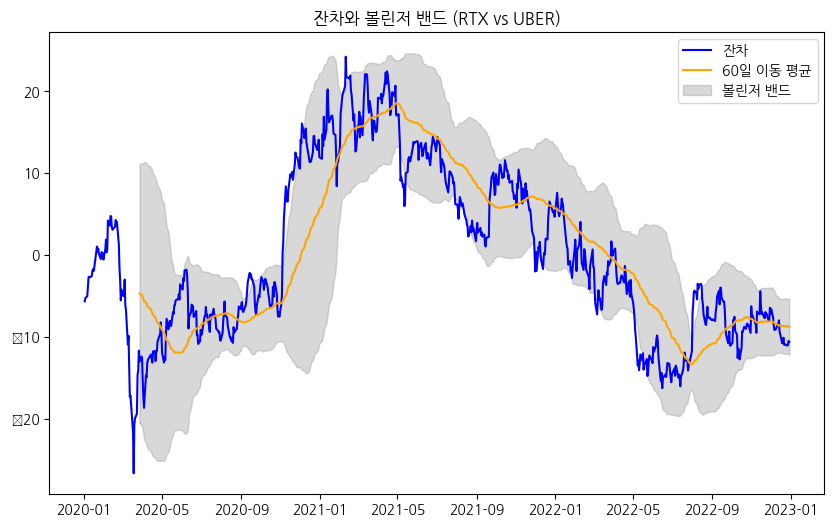

In [153]:
# 8. Industrials 섹터의 모든 페어 분석

financials_tickers = top_by_sector.loc['Industrials']['Symbol'].tolist()
analyze_sector_pairs(financials_tickers, start_date=default_start_date, end_date=default_end_date)

#### 8. 안정적 페어

[*********************100%***********************]  10 of 10 completed


Pair: GE and CAT - 잔차 표준편차: 27.045084162112307, ADF p-value: 0.5435291801375648
Pair: GE and RTX - 잔차 표준편차: 11.279980234156136, ADF p-value: 0.8038220412041219
Pair: GE and UBER - 잔차 표준편차: 8.025452795443005, ADF p-value: 0.259290465094723
Pair: GE and UNP - 잔차 표준편차: 23.274701968640564, ADF p-value: 0.22747428085579213
Pair: GE and LMT - 잔차 표준편차: 43.27563065041801, ADF p-value: 0.6011984516030988
Pair: GE and HON - 잔차 표준편차: 15.13085408409145, ADF p-value: 0.16564716972346039
Pair: GE and ETN - 잔차 표준편차: 20.666412035883788, ADF p-value: 0.2587295677649817
Pair: GE and ADP - 잔차 표준편차: 32.778550181983924, ADF p-value: 0.792861334183244
Pair: GE and UPS - 잔차 표준편차: 29.040338649644845, ADF p-value: 0.15969025344133203
Pair: CAT and RTX - 잔차 표준편차: 9.825458027266965, ADF p-value: 0.07189623938548594
Pair: CAT and UBER - 잔차 표준편차: 9.879692132118375, ADF p-value: 0.6169567633727497
Pair: CAT and UNP - 잔차 표준편차: 15.910686855383638, ADF p-value: 0.25993164557774495
Pair: CAT and LMT - 잔차 표준편차: 39.86136

C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


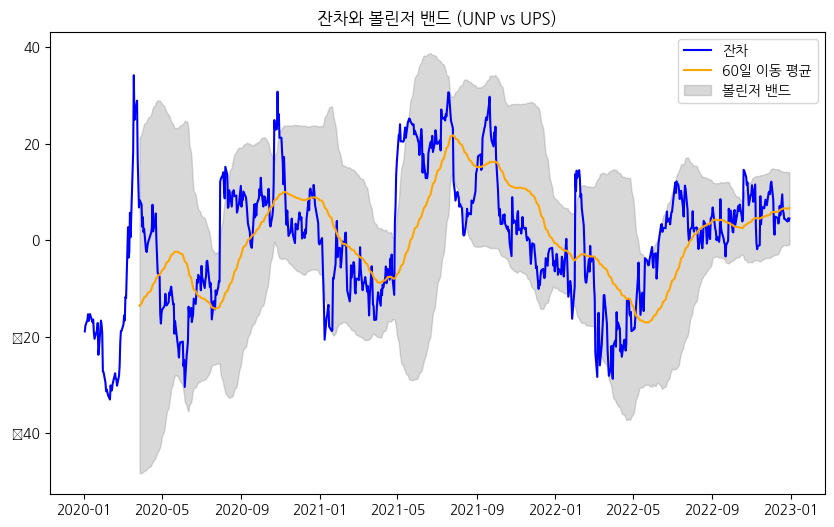

Industrialsn Services 가장 안정적인 페어: ('UNP', 'UPS')


In [154]:
# Industrials 섹터의 시가총액 상위 10개 종목 선택 (기존 4개에서 확장)
industrials_top = sp500[sp500['GICS Sector'] == 'Industrials'].nlargest(10, 'Market Cap')

# Industrials Services 섹터의 종목 티커 리스트 생성
industrials_tickers = industrials_top['Symbol'].tolist()

# 페어 분석 및 안정적인 페어 선택 (ADF p-value 기준 0.1로 설정)
stable_industrials_pair = select_stable_pair(industrials_tickers, start_date=default_start_date, end_date=default_end_date, adf_threshold=0.05)
print(f"Industrialsn Services 가장 안정적인 페어: {stable_industrials_pair}")


### 9. Materials

#### 9. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed



Analyzing Pair: LIN and SHW


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


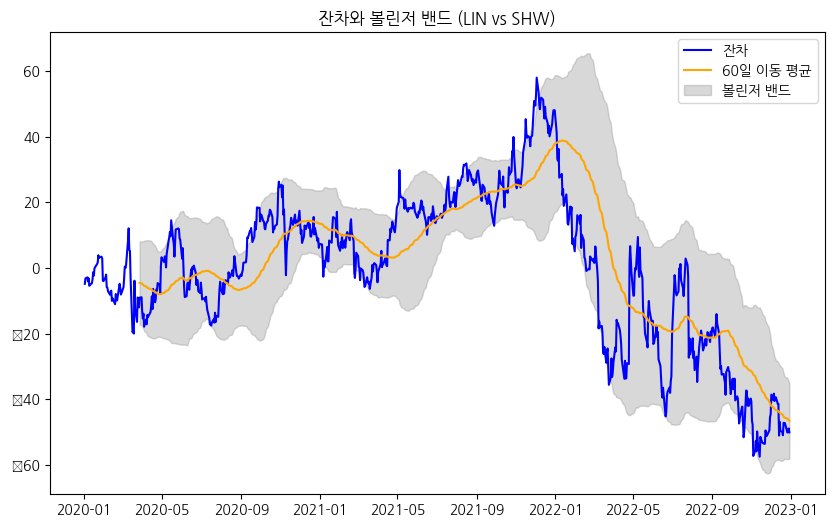


Analyzing Pair: LIN and ECL


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


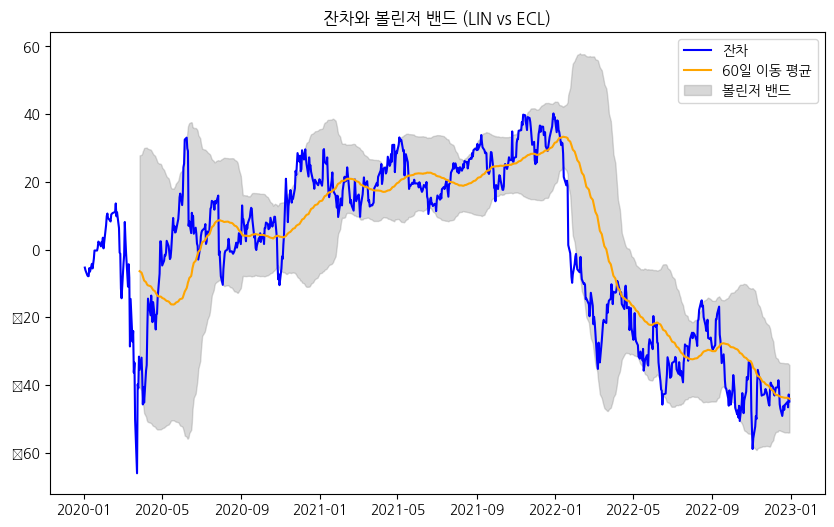


Analyzing Pair: LIN and FCX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


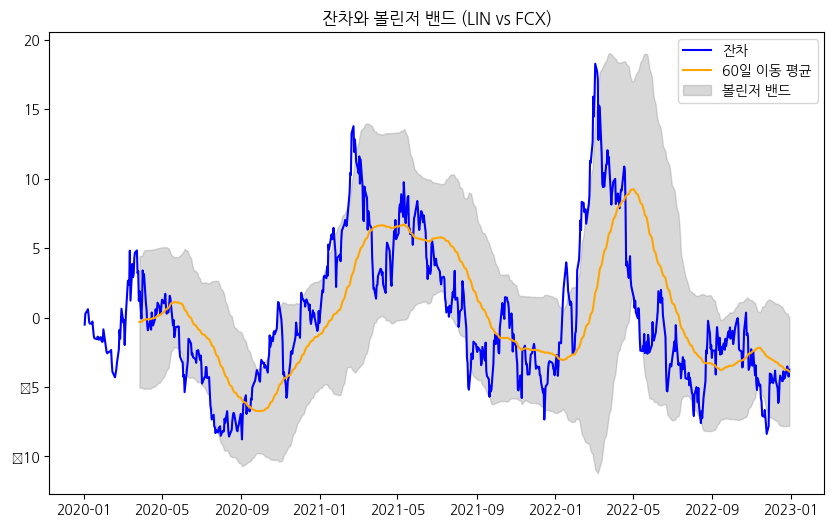


Analyzing Pair: SHW and ECL


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


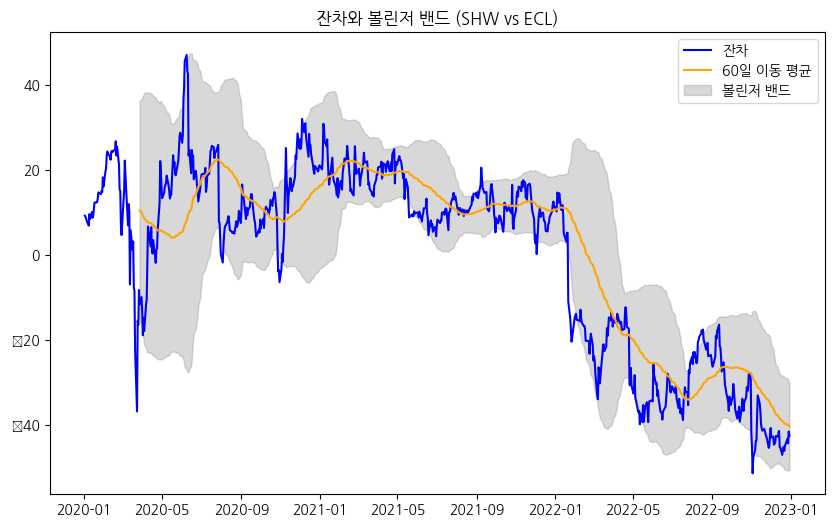


Analyzing Pair: SHW and FCX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


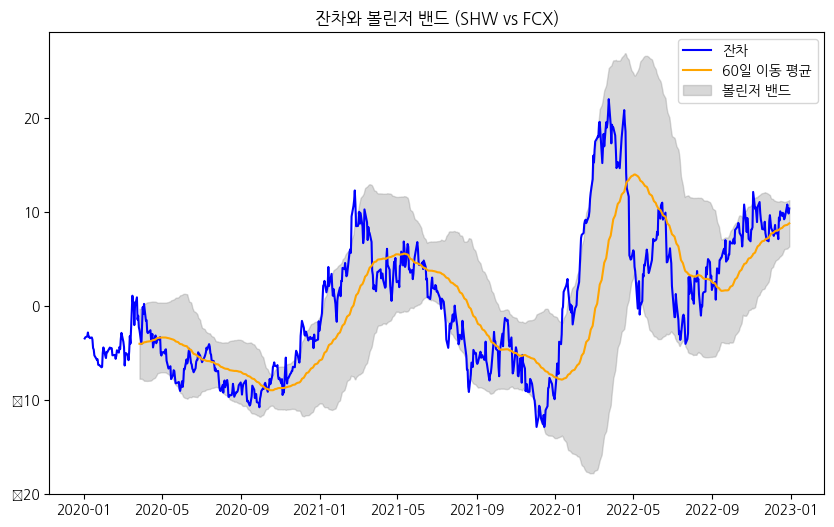


Analyzing Pair: ECL and FCX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


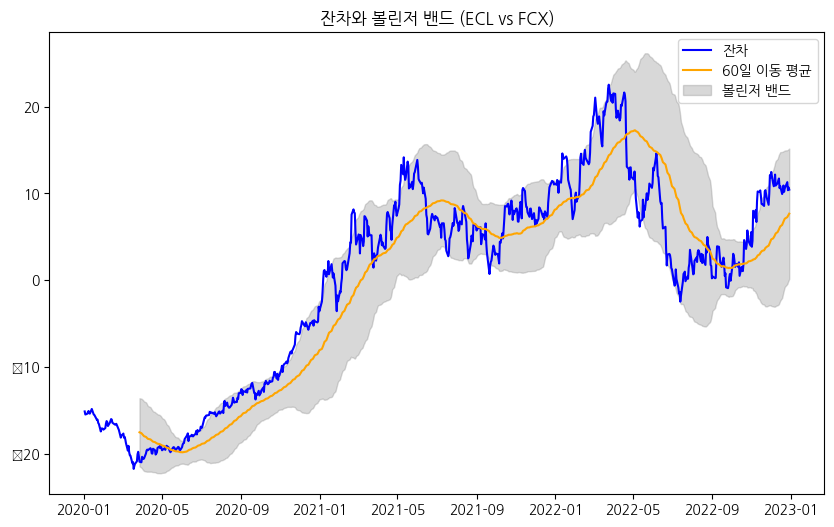

In [155]:
# 9. Materials 섹터의 모든 페어 분석

financials_tickers = top_by_sector.loc['Materials']['Symbol'].tolist()
analyze_sector_pairs(financials_tickers, start_date=default_start_date, end_date=default_end_date)

#### 9. 안정적 페어

[*********************100%***********************]  10 of 10 completed


Pair: LIN and SHW - 잔차 표준편차: 23.231248725508575, ADF p-value: 0.37670707794615393
Pair: LIN and ECL - 잔차 표준편차: 25.04691959844193, ADF p-value: 0.5921502654120891
Pair: LIN and FCX - 잔차 표준편차: 5.023149853136397, ADF p-value: 0.1490249213770663
Pair: LIN and APD - 잔차 표준편차: 21.559426777024747, ADF p-value: 0.14978615473578066
Pair: LIN and NEM - 잔차 표준편차: 8.122532473819644, ADF p-value: 0.2731122593086423
Pair: LIN and CTVA - 잔차 표준편차: 6.893398864794698, ADF p-value: 0.4524730737669797
Pair: LIN and DOW - 잔차 표준편차: 5.35110824377562, ADF p-value: 0.26636447781602923
Pair: LIN and NUE - 잔차 표준편차: 18.008002434298366, ADF p-value: 0.1617547648419192
Pair: LIN and DD - 잔차 표준편차: 7.608315008117989, ADF p-value: 0.30660425827916604
Pair: SHW and ECL - 잔차 표준편차: 22.06528299086753, ADF p-value: 0.7031488126803072
Pair: SHW and FCX - 잔차 표준편차: 7.2627526340119255, ADF p-value: 0.28419055442901664
Pair: SHW and APD - 잔차 표준편차: 20.767747371089076, ADF p-value: 0.26674400056954717
Pair: SHW and NEM - 잔차 표준편차: 7

C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


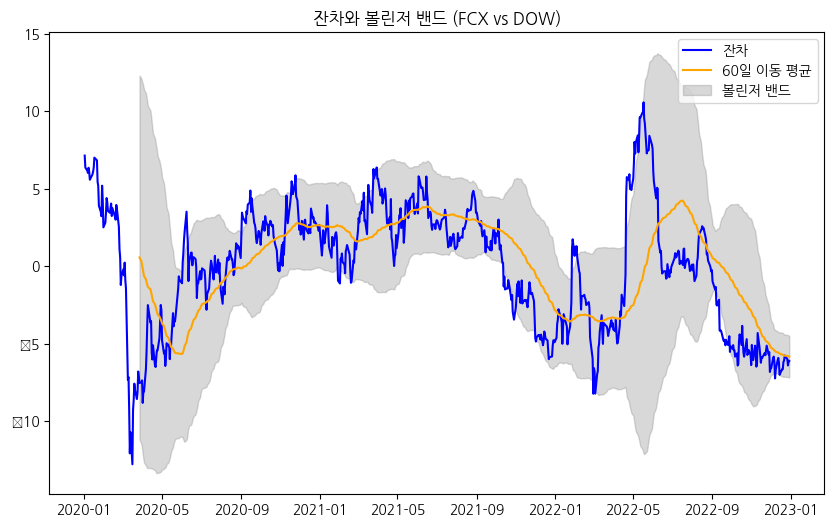

Materials 가장 안정적인 페어: ('FCX', 'DOW')


In [156]:
# Materials 섹터의 시가총액 상위 10개 종목 선택 (기존 4개에서 확장)
materials_top = sp500[sp500['GICS Sector'] == 'Materials'].nlargest(10, 'Market Cap')

# Materials 섹터의 종목 티커 리스트 생성
materials_tickers = materials_top['Symbol'].tolist()

# 페어 분석 및 안정적인 페어 선택 (ADF p-value 기준 0.05로 설정)
stable_materials_pair = select_stable_pair(materials_tickers, start_date=default_start_date, end_date=default_end_date, adf_threshold=0.05)
print(f"Materials 가장 안정적인 페어: {stable_materials_pair}")


### 10. Real Estate

#### 10. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



Analyzing Pair: PLD and AMT


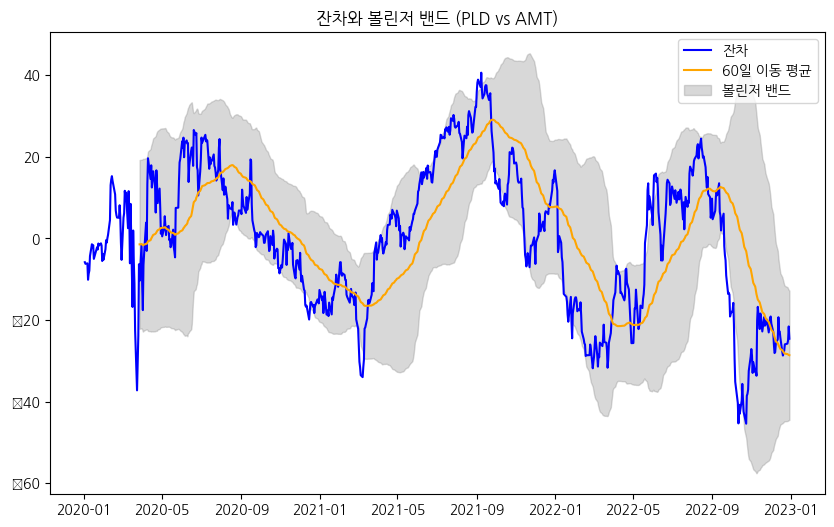


Analyzing Pair: PLD and EQIX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


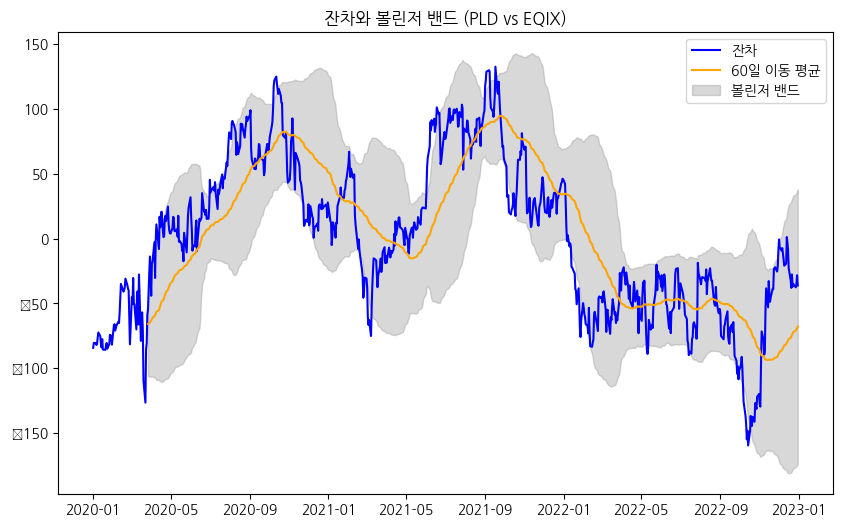


Analyzing Pair: PLD and WELL


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


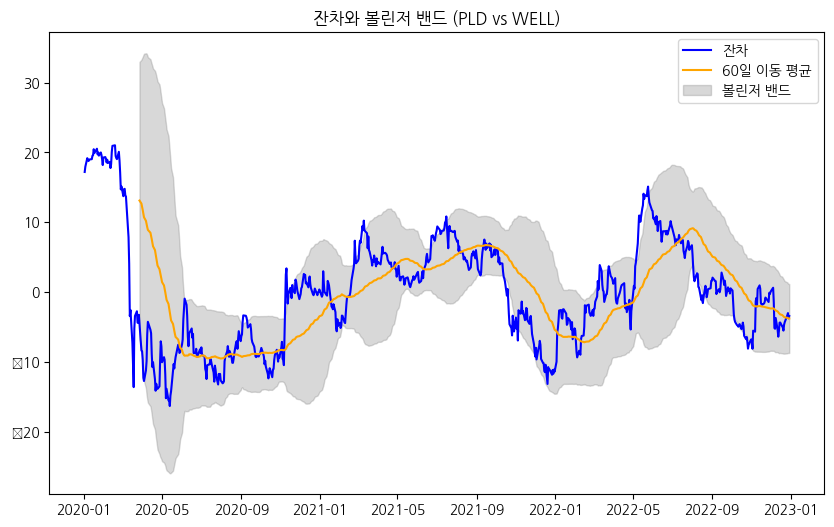


Analyzing Pair: AMT and EQIX


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


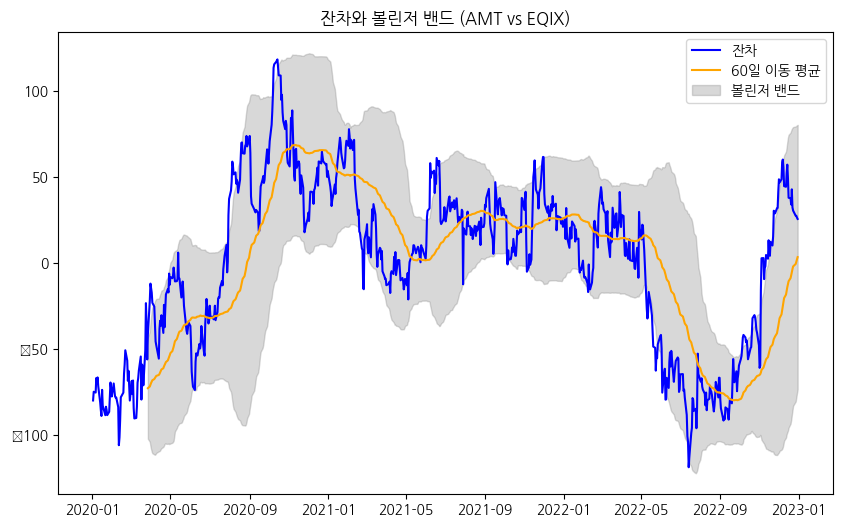


Analyzing Pair: AMT and WELL


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


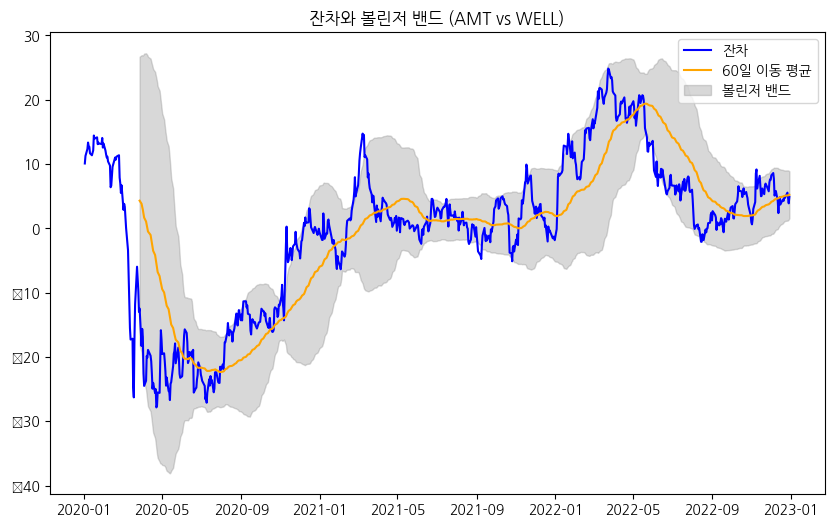


Analyzing Pair: EQIX and WELL


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


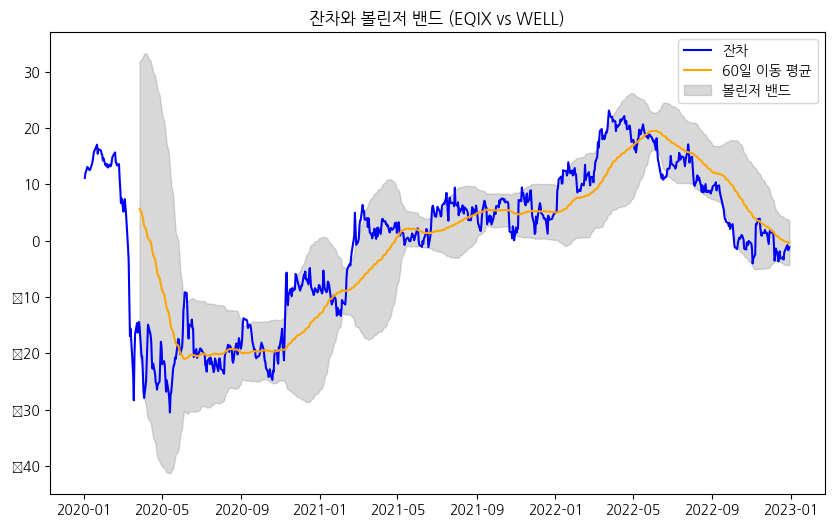

In [157]:
# 10. Real Estate 섹터의 모든 페어 분석

financials_tickers = top_by_sector.loc['Real Estate']['Symbol'].tolist()
analyze_sector_pairs(financials_tickers, start_date=default_start_date, end_date=default_end_date)

#### 10. 안정적 페어 

[*********************100%***********************]  4 of 4 completed


Pair: PLD and AMT - 잔차 표준편차: 17.49409883807628, ADF p-value: 0.20078668145350675
Pair: PLD and EQIX - 잔차 표준편차: 60.897104753885195, ADF p-value: 0.23063067045963787
Pair: PLD and WELL - 잔차 표준편차: 7.915203568945948, ADF p-value: 0.0065790394860740925
Pair: AMT and EQIX - 잔차 표준편차: 48.40601215570933, ADF p-value: 0.1033788227025943
Pair: AMT and WELL - 잔차 표준편차: 11.714464560811674, ADF p-value: 0.2408867490447067
Pair: EQIX and WELL - 잔차 표준편차: 13.0404460255909, ADF p-value: 0.25518988866439973

Analyzing Pair: PLD and WELL


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


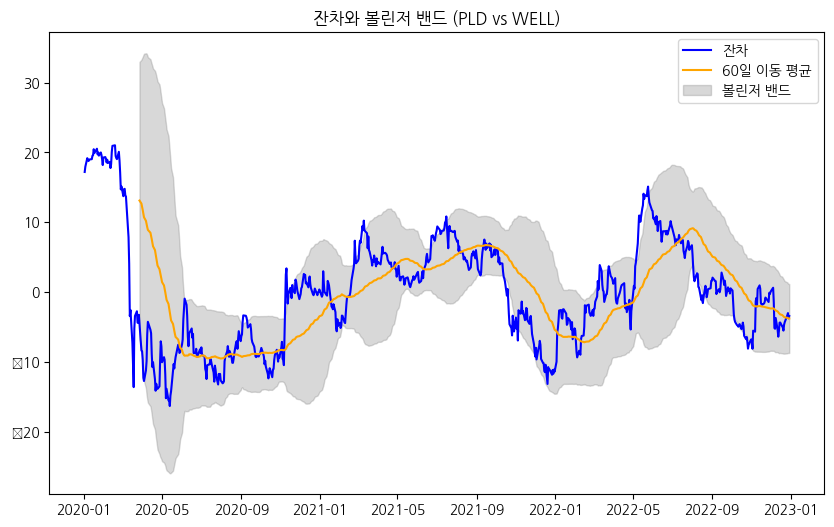

가장 안정적인 페어: ('PLD', 'WELL')


In [158]:
# Real Estate 섹터의 가장 안정적인 페어 선택
it_sector_tickers = top_by_sector.loc['Real Estate']['Symbol'].tolist()
stable_it_pair = select_stable_pair(it_sector_tickers, start_date=default_start_date, end_date=default_end_date)
print(f"가장 안정적인 페어: {stable_it_pair}")


### 11. Utilities

#### 11. 모든 페어 분석

[*********************100%***********************]  4 of 4 completed



Analyzing Pair: NEE and SO


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


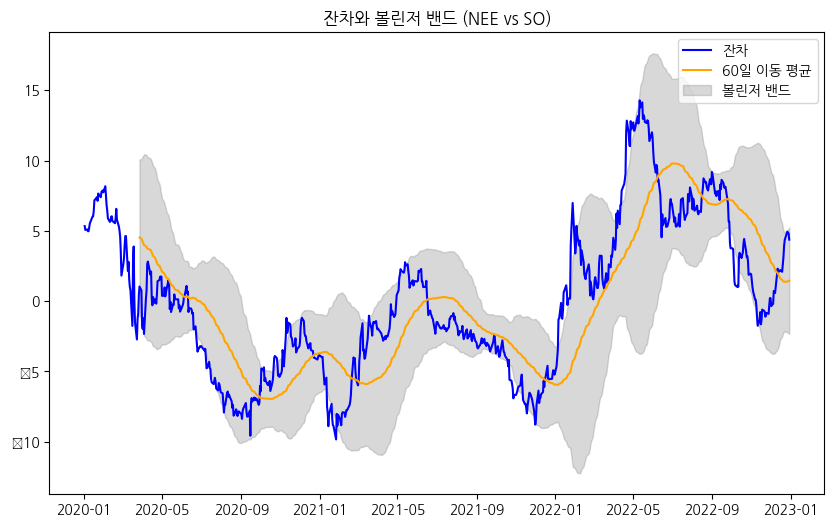


Analyzing Pair: NEE and DUK


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


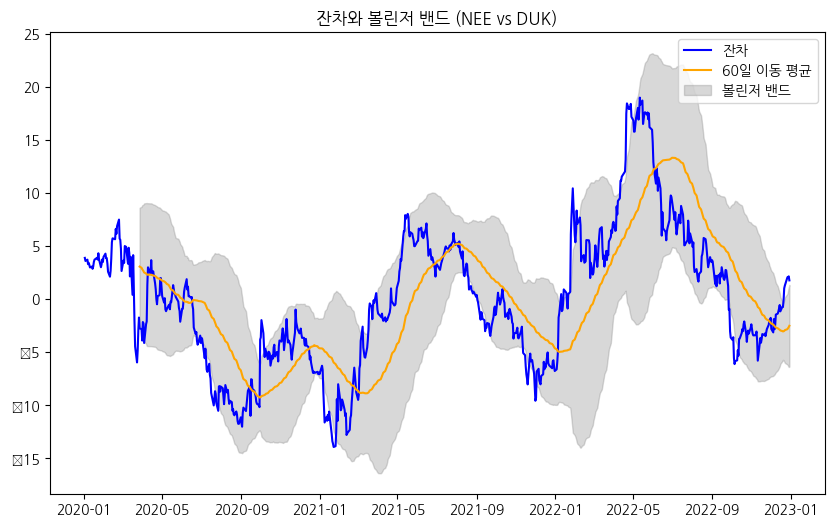


Analyzing Pair: NEE and CEG


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


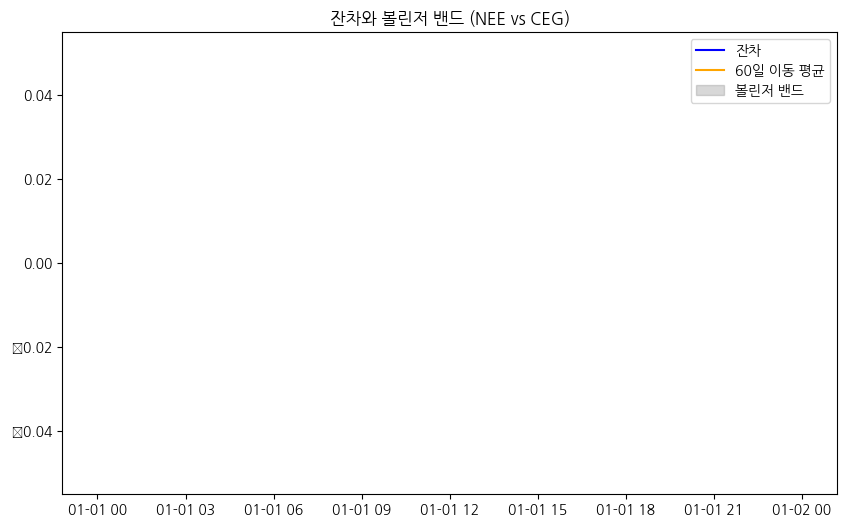


Analyzing Pair: SO and DUK


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


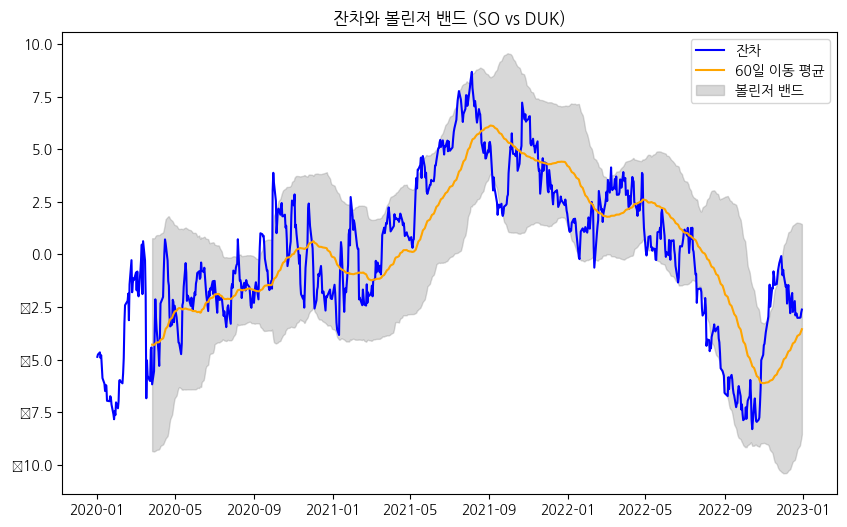


Analyzing Pair: SO and CEG


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


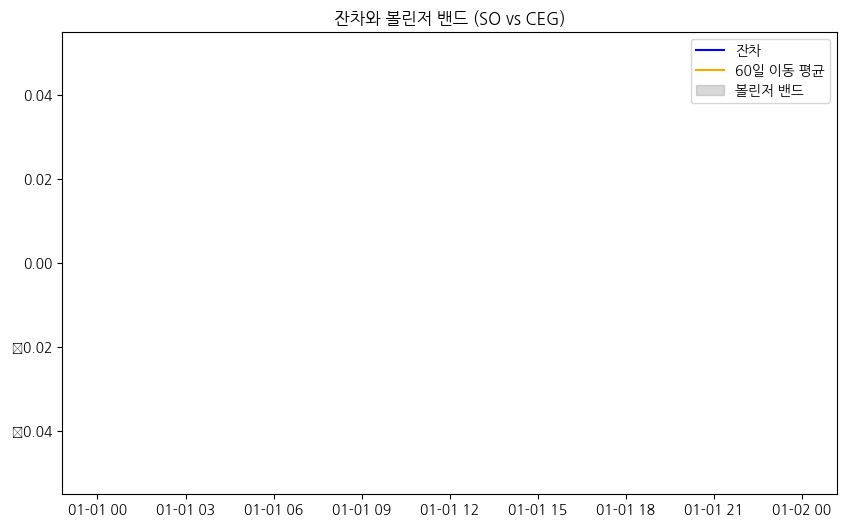


Analyzing Pair: DUK and CEG


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


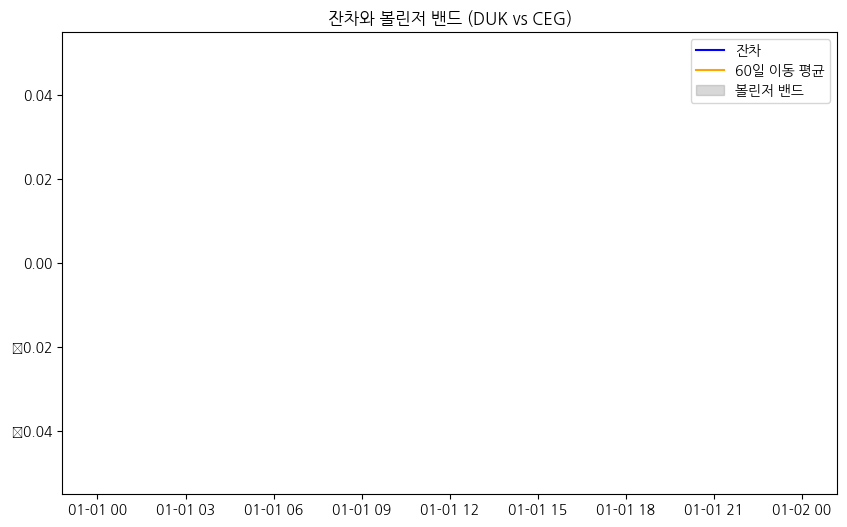

In [159]:
# 11. Utilities 섹터의 모든 페어 분석

financials_tickers = top_by_sector.loc['Utilities']['Symbol'].tolist()
analyze_sector_pairs(financials_tickers, start_date=default_start_date, end_date=default_end_date)

#### 11 안정적 페어

[*********************100%***********************]  4 of 4 completed


Pair: NEE and SO - 잔차 표준편차: 5.320992094592371, ADF p-value: 0.2666160860627432
Pair: NEE and DUK - 잔차 표준편차: 6.5163088219693455, ADF p-value: 0.2666068576136479
Pair: NEE and CEG contains insufficient data (all NaNs or infs). Skipping this pair.
Pair: SO and DUK - 잔차 표준편차: 3.6039970543940223, ADF p-value: 0.062187749794287664
Pair: SO and CEG contains insufficient data (all NaNs or infs). Skipping this pair.
Pair: DUK and CEG contains insufficient data (all NaNs or infs). Skipping this pair.

Analyzing Pair: SO and DUK


C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


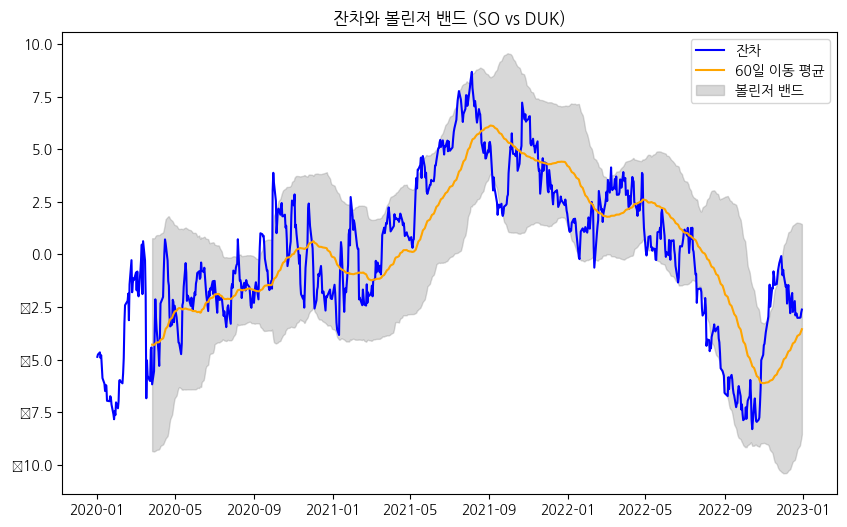

가장 안정적인 페어: ('SO', 'DUK')


In [ ]:
# Utilities 섹터의 가장 안정적인 페어 선택
it_sector_tickers = top_by_sector.loc['Utilities']['Symbol'].tolist()
stable_it_pair = select_stable_pair(it_sector_tickers, start_date=default_start_date, end_date=default_end_date, adf_threshold = 0.1)
print(f"가장 안정적인 페어: {stable_it_pair}")
